# ⚡ Stage 3 - Machine Learning Project: Electricity Price Explanation ⚙️📉

**LANOTTE-MORO Alix, CHANDECLERC Antoine, GILLES Julien, FLEURY Nathan**  
**December 6, 2024**

### Stage 1 and Stage 2 has already covered parts I to VIII. . The main work of this third stage will be addressed from part IX onwards

## Project Overview

This project focuses on analyzing daily variations in electricity futures prices within the European market, specifically for France and Germany. Given the complex interplay of meteorological, energy production, and geopolitical factors impacting price fluctuations, the objective is to build a model that explains these movements rather than predicting exact prices. Leveraging Spearman correlation as the primary evaluation metric, we will employ a range of models—from linear regression benchmarks to advanced machine learning approaches (e.g., Random Forests, XGBoost, and RNNs)—to capture both linear and non-linear influences on price variations. This model aims to support energy producers, traders, and policymakers by providing insights to optimize trading strategies, manage risks, and strengthen the resilience of the European energy grid.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

import warnings 
warnings.filterwarnings("ignore")

## I Data Importation and first preview

In [2]:
X_df =pd.read_csv('X_train_NHkHMNU.csv', delimiter= ',')
y_df =pd.read_csv('y_train_ZAN5mwg.csv', delimiter= ',')
X_test_df =pd.read_csv('X_test_final.csv', delimiter= ',')

df = pd.merge(X_df,y_df,on='ID')

print(df.shape)
df.head(10)

(1494, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,FR,-0.295296,-0.765120,-0.717490,0.717490,-1.117139,-0.200305,1.117139,...,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457,0.932105
6,1546,144,FR,-0.234965,-0.677085,0.399588,-0.399588,0.183998,-0.986235,-0.183998,...,-1.658394,-0.529800,-0.318920,-1.220760,-0.512991,0.147507,1.889739,0.498226,0.681739,0.192680
7,1069,1136,FR,0.332223,-0.546797,-0.507773,0.507773,NaN,0.569585,NaN,...,-0.744328,-0.051535,-0.701035,-0.394857,1.990978,0.902719,0.206769,0.993304,-0.223739,0.112850
8,1323,83,FR,-0.023023,-0.604694,-1.196787,1.196787,-0.519339,0.373109,0.519339,...,-0.207390,0.009356,-0.261496,-0.841560,-1.024980,-1.564174,2.688208,3.061210,3.755240,0.076153
9,1618,307,FR,0.564657,0.273776,-0.439063,0.439063,-0.636654,0.342057,0.636654,...,-0.972344,-0.806435,-0.752273,-0.767578,-0.371475,-0.459768,-1.487154,-0.692378,-0.768283,0.000000


### Pourcentage of missing values by columns

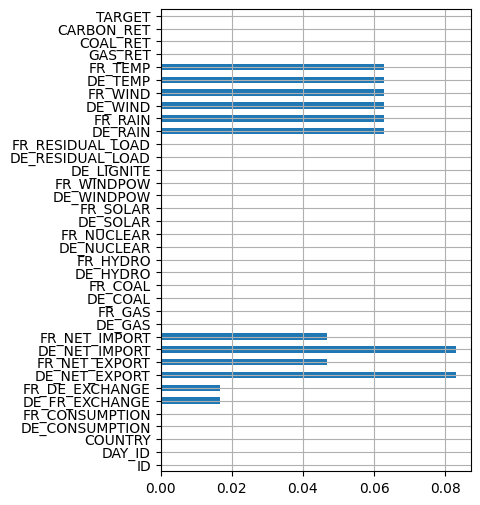

In [3]:
nb_missing = df.isna().sum()
rate_missing = nb_missing / df.ID.nunique()
fig, ax = plt.subplots(figsize=(4,6))
ax1 = ax
rate_missing.plot(kind="barh", ax=ax1)
ax1.grid()

We notice that there are a certain number of missing values, particularly for DE_NET_IMPORT and DE_NET_EXPORT, where the rate exceeds 8%. These data will need to be handled. Several options are available to us: filling them with the mean, replacing them with zeros, etc.

We chose to fill the missing values in each column with the respective column mean. Since the dataset is relatively small (around 1500 rows), dropping rows with missing values would significantly reduce the available data. By imputing missing values with the mean, we retain as many rows as possible, ensuring that the dataset remains comprehensive.

In [4]:
#List of Columns with missing values
columns_to_fill = [
    "DE_FR_EXCHANGE", "FR_DE_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT", 
    "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_RAIN", "FR_RAIN", 
    "DE_WIND", "FR_WIND", "DE_TEMP", "FR_TEMP"
]
df_general = df

df.fillna(0)

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,0.000000,0.692860,0.000000,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,0.000000,0.990324,0.000000,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876984,0.819520,1.320373,-0.172597
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932633,-0.085690,0.356356,-0.063546
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,0.151797
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,-0.640917


### Plot of the distribution of each columns of the data

Text(0.5, 1.0, 'TARGET')

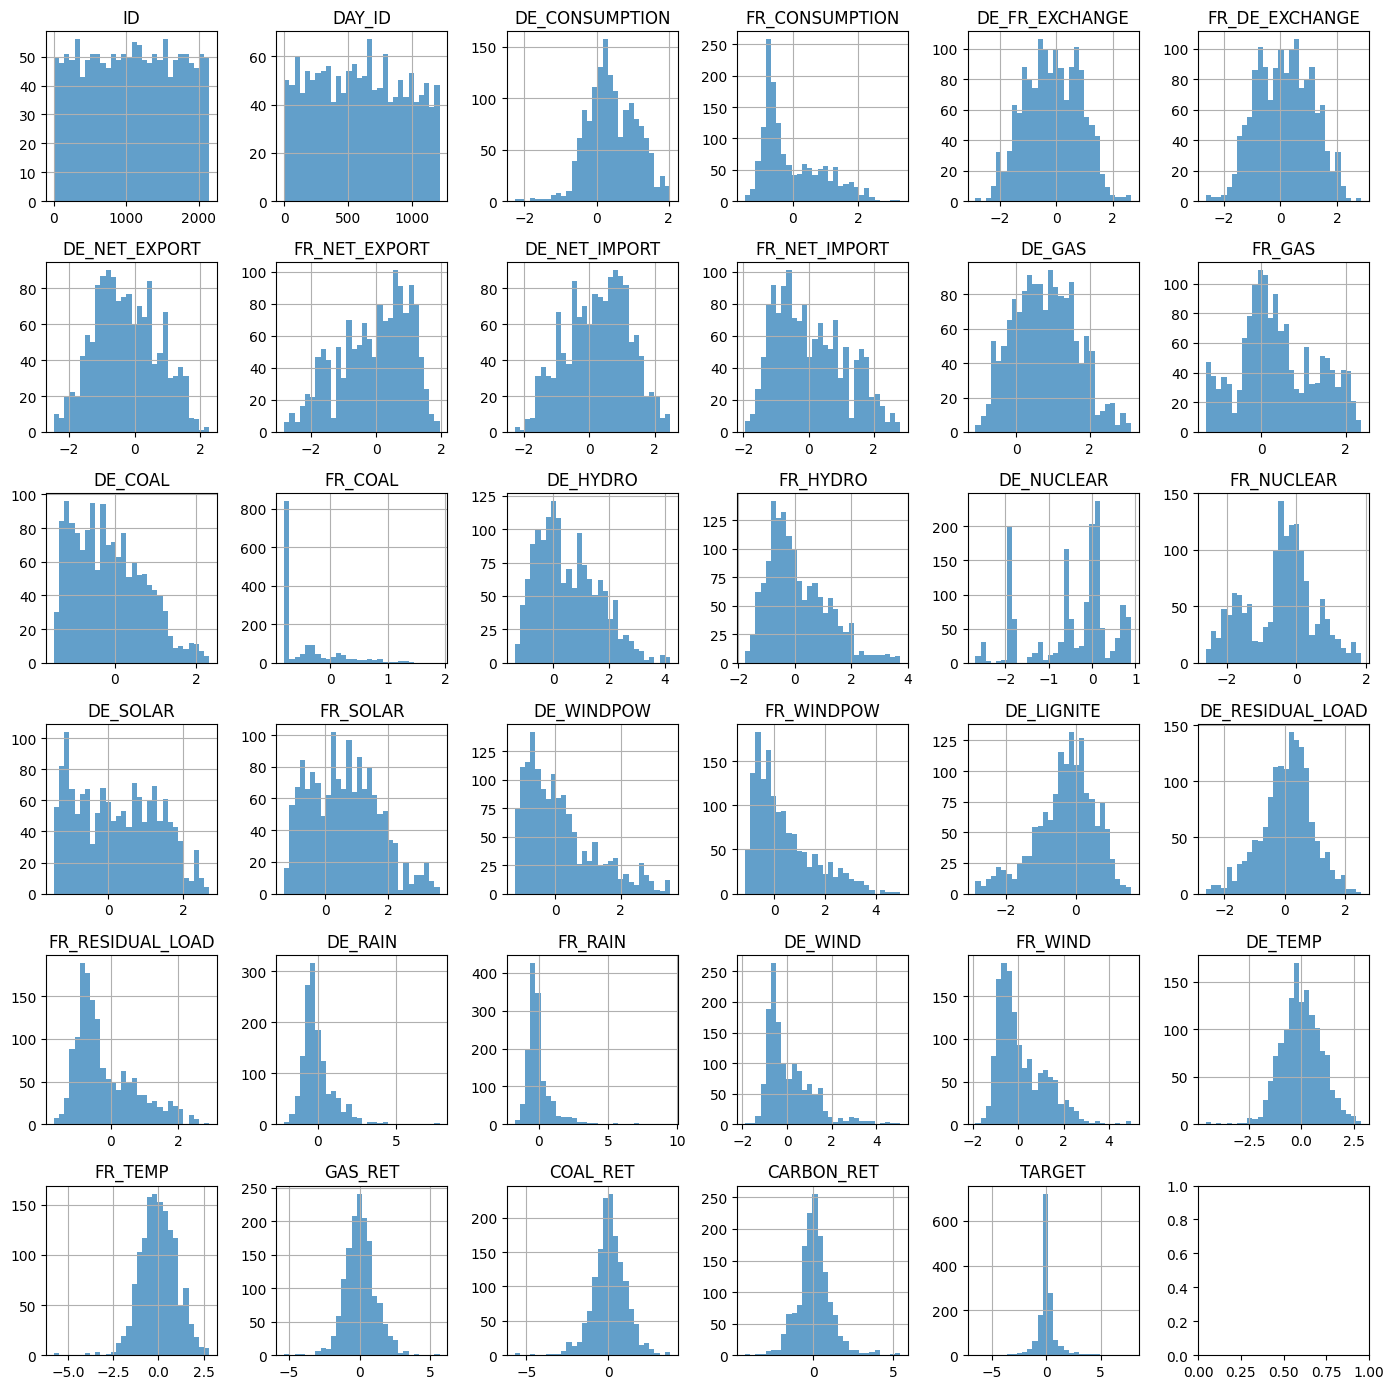

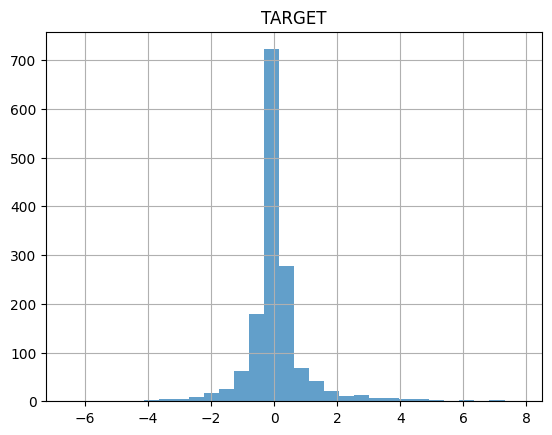

In [5]:
features = [feature for feature in df.columns if feature != "COUNTRY"]

nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df[feature].hist(bins= 30, ax=ax1, alpha=0.7)

plt.tight_layout()

fig, ax = plt.subplots()
ax1 = ax
y_df["TARGET"].hist(bins= 30, ax=ax1, alpha=0.7)
ax1.set_title("TARGET")

In [6]:
#Distribution data points by country
print("Nb of data points by country:")
print(df.COUNTRY.value_counts())

Nb of data points by country:
COUNTRY
FR    851
DE    643
Name: count, dtype: int64


We aim to predict prices for France and Germany. To better understand the factors influencing price in each country, we will plot the data separately. This allows us to evaluate whether the factors driving price variations are consistent or differ between the two countries.

In [7]:
#Divide the data by country
df_de = df[df['COUNTRY'] == 'DE']
df_de = df_de.drop(columns=['COUNTRY'])

df_fr = df[df.COUNTRY == "FR"]
df_fr = df_fr.drop(columns=['COUNTRY'])

### Plot of the distribution of each column by country

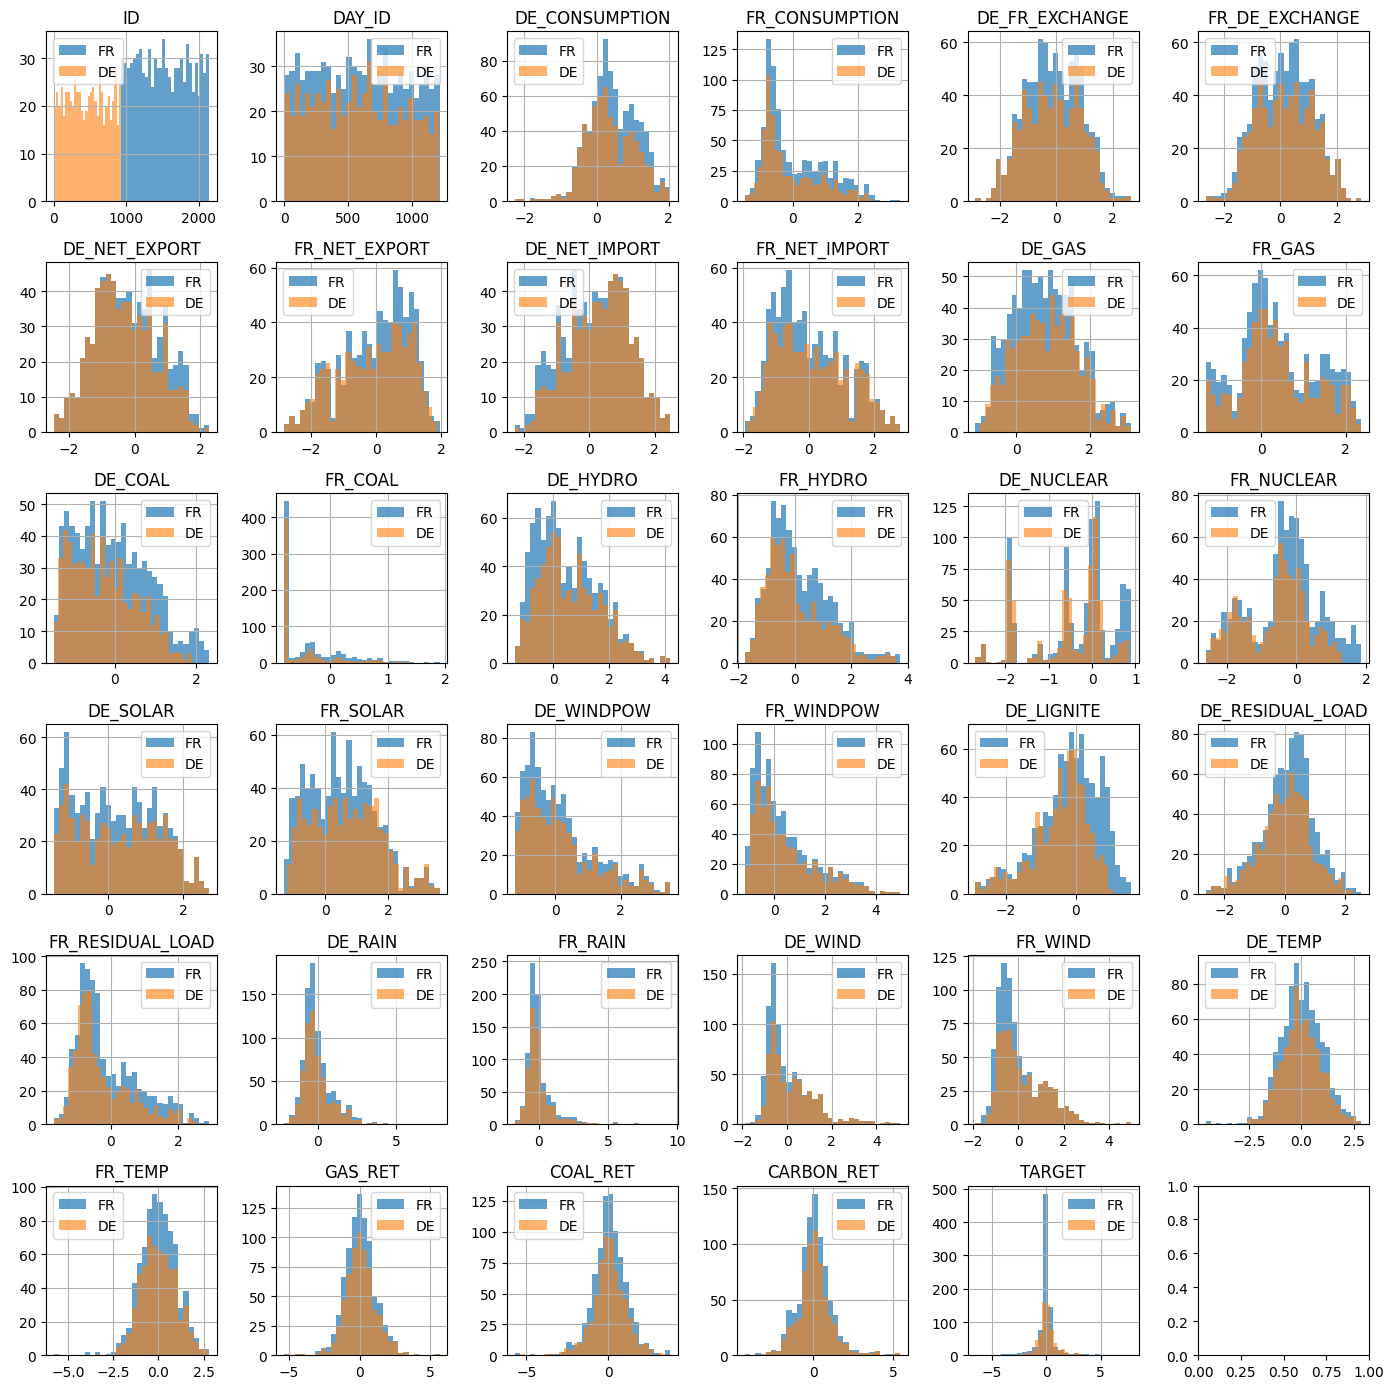

In [8]:
nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df_fr[feature].hist(bins= 30, ax=ax1, alpha=0.7, label= "FR")
    df_de[feature].hist(bins= 30, ax=ax1, alpha=0.6, label= "DE")
    ax1.legend()

plt.tight_layout()

We observe that the **distributions of various features** are generally similar between **France** and **Germany**. However, it is notable that the data associated with **Germany** exhibit greater **variability** across several variables. This can be attributed to a more **comprehensive** and **dense database** on the French side.  

It could be relevant to separate the data into **two distinct sets** to develop **specific models** for each country. Indeed, the **economic differences** between France and Germany are significant and can influence their respective behaviors, particularly regarding **electricity prices**. These differences are attributable to several factors, including:  

- **The structure of the energy mix**: France relies heavily on **nuclear energy**, whereas Germany has gradually reduced its use of nuclear energy in favor of **renewable sources** such as wind and solar. This creates differing dynamics in electricity supply and **sensitivity to weather conditions**.  

- **Energy policies**: The energy strategies differ between the two countries, with a faster energy transition in **Germany**, accompanied by **subsidy and regulatory policies** to promote renewables. In France, dependence on nuclear energy leads to a policy focus on **supply stability**.  

- **Climatic and geographical conditions**: Climatic variations, such as differences in **temperature** and **precipitation**, differently affect energy consumption in each country. For instance, France may experience higher heating demand in winter, while Germany, with its significant **wind power infrastructure**, is more impacted by wind variations.  

These differences suggest that a single model might not adequately capture the unique dynamics of each country. Therefore, an approach using **separate models** for **France** and **Germany** could better reflect their economic and energy-specific characteristics.


### Analysis of Data Availability 

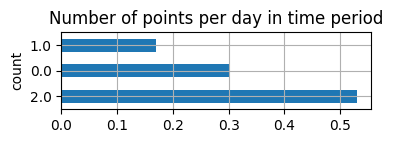

In [9]:
F = df.DAY_ID.value_counts().sort_index()
F = F.reindex(range(F.index.max()))
F = F.fillna(0)
F = F.value_counts()
F /= F.sum()
fig, ax = plt.subplots(figsize=(4,1))
ax1 = ax
ax1.set_title("Number of points per day in time period")
F.plot(kind="barh", ax=ax1)
ax1.grid()

The distribution of days based on data availability (53% of days with data for both countries, 30% without data, and the remainder with partial data available for only one of the two countries) provides important insights into the quality and representativeness of the sample used in our analysis.  

This distribution highlights the need to adopt strategies for handling missing data. Two approaches can be considered:  

- **Separate models by country** for days where data is available for only one country.  
- **Imputation or exclusion of days without data**, depending on their proportion and the potential impact on the analysis.  

These observations call for caution when interpreting the results, as irregular data availability may affect conclusions regarding temporal phenomena or direct comparisons between France and Germany.



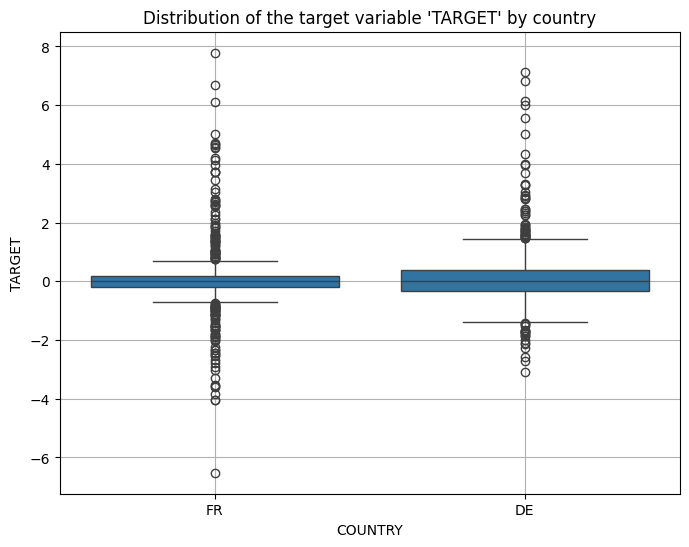

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="COUNTRY", y="TARGET", data=df)
plt.title("Distribution of the target variable 'TARGET' by country")
plt.xlabel("COUNTRY")
plt.ylabel("TARGET")
plt.grid(True)
plt.show()

Examining the distribution of the target variable for both countries reveals that the median is similar and close to zero for both France and Germany. This suggests that the target values are well **centered around zero** in both cases, indicating a generally balanced distribution of positive and negative values. This centrality can be interpreted as follows:  

- **Absence of trend bias**: The proximity of the median to zero for both countries suggests there is no systematic bias in the target values. In other words, the values do not skew significantly toward positive or negative levels, which is favorable for comparative analyses or symmetric predictive models.  
- **Quantile**: The interquartile range is slightly narrower for France, meaning that most TARGET values are more concentrated around the median compared to Germany. However, the presence of numerous outliers in Francesignificantly extends the range of extreme values, potentially requiring special handling to prevent undue influence on the models.  

#### Presence of Outliers  

Another striking aspect is the presence of **numerous outliers in the French data**, whereas extreme values are less frequent in Germany. This could reflect several dynamics:  

- **Increased variability in French data**: The higher frequency of extreme values in France might indicate greater volatility in the market or factors influencing the target variable.  
- **Influence of country-specific conditions**: France and Germany differ in infrastructure and energy mix (e.g., France's heavier reliance on nuclear energy compared to Germany). These structural differences could lead to extreme variations in certain energy indicators, especially during crises or periods of exceptional demand.  
- **Potential impact on predictive models**: These outliers could complicate modeling for the French data. Extreme values might influence the mean and variance, which could affect models sensitive to significant deviations. Techniques for managing outliers (e.g., data transformation or smoothing extreme values) may be necessary to enhance model robustness.  

#### Implications for Analysis  

The observations regarding centrality and outliers have several implications for analysis and modeling:  

1. **Strategies for managing extreme values**: The outliers in the French data may require special handling, such as outlier removal or the application of normalization or logarithmic transformation techniques to reduce their impact.  
2. **Country-specific approaches**: Since the target variable's distribution differs between France and Germany (particularly regarding outliers), it may be advisable to build separate models or apply differentiated preprocessing for each country.  
3. **Use of robust models**: In the presence of numerous outliers, more robust models, such as those based on the median (quantile regression) or ensemble algorithms (e.g., random forest or gradient boosting), might be better suited than standard linear models.  

#### Summary  

Although the French and German distributions of the target variable exhibit similar centrality, the higher frequency of outliers in France calls for a cautious approach. Proper handling of these outliers is essential to ensure the quality of results and the robustness of predictive models.


### Pearson's Correlation Matrix

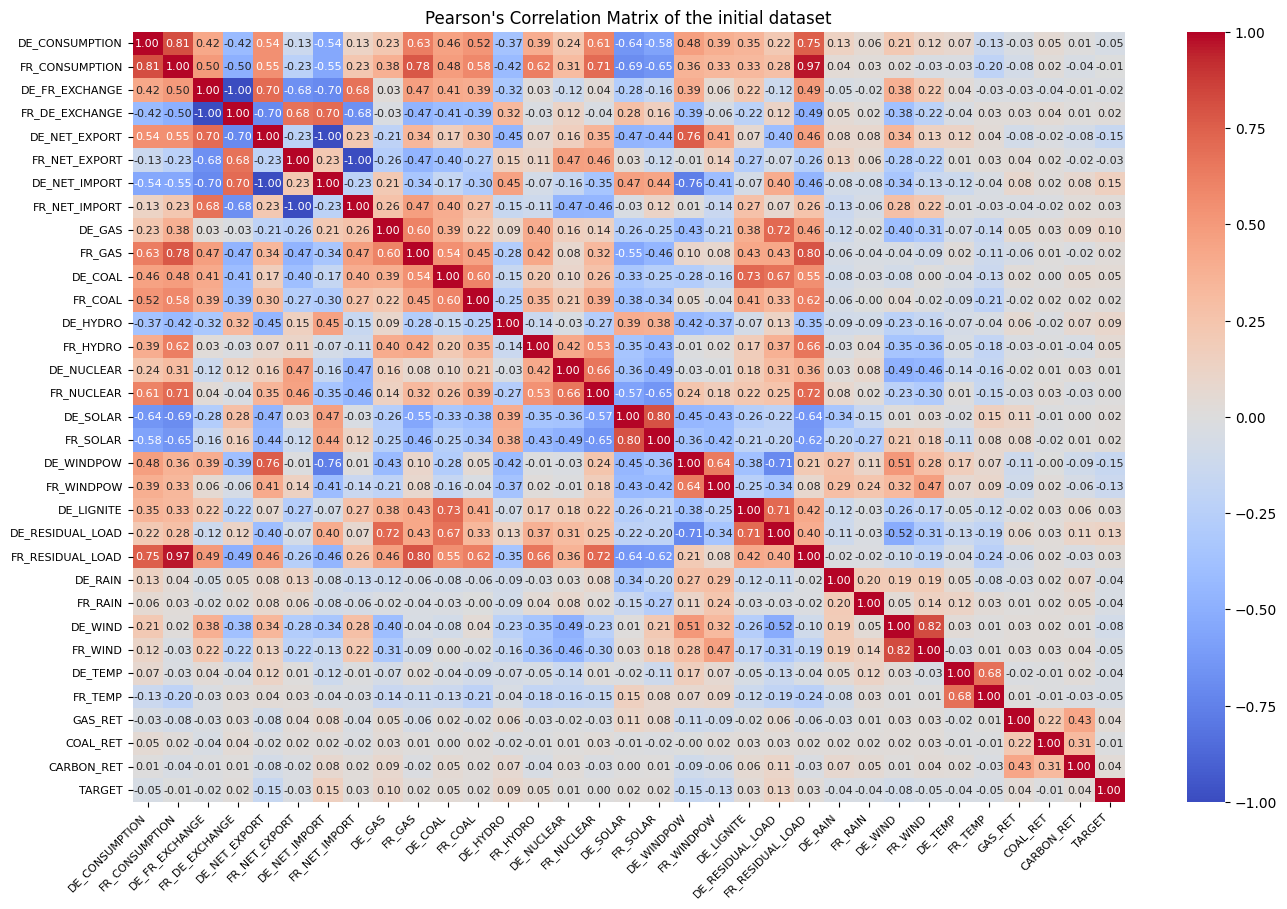

In [11]:
plt.figure(figsize=(16, 10))
df_cleaned = df_general.drop(columns=['ID', 'DAY_ID','COUNTRY'])
pearson_corr = df_cleaned.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()


### Spearman's Correlation Matrix

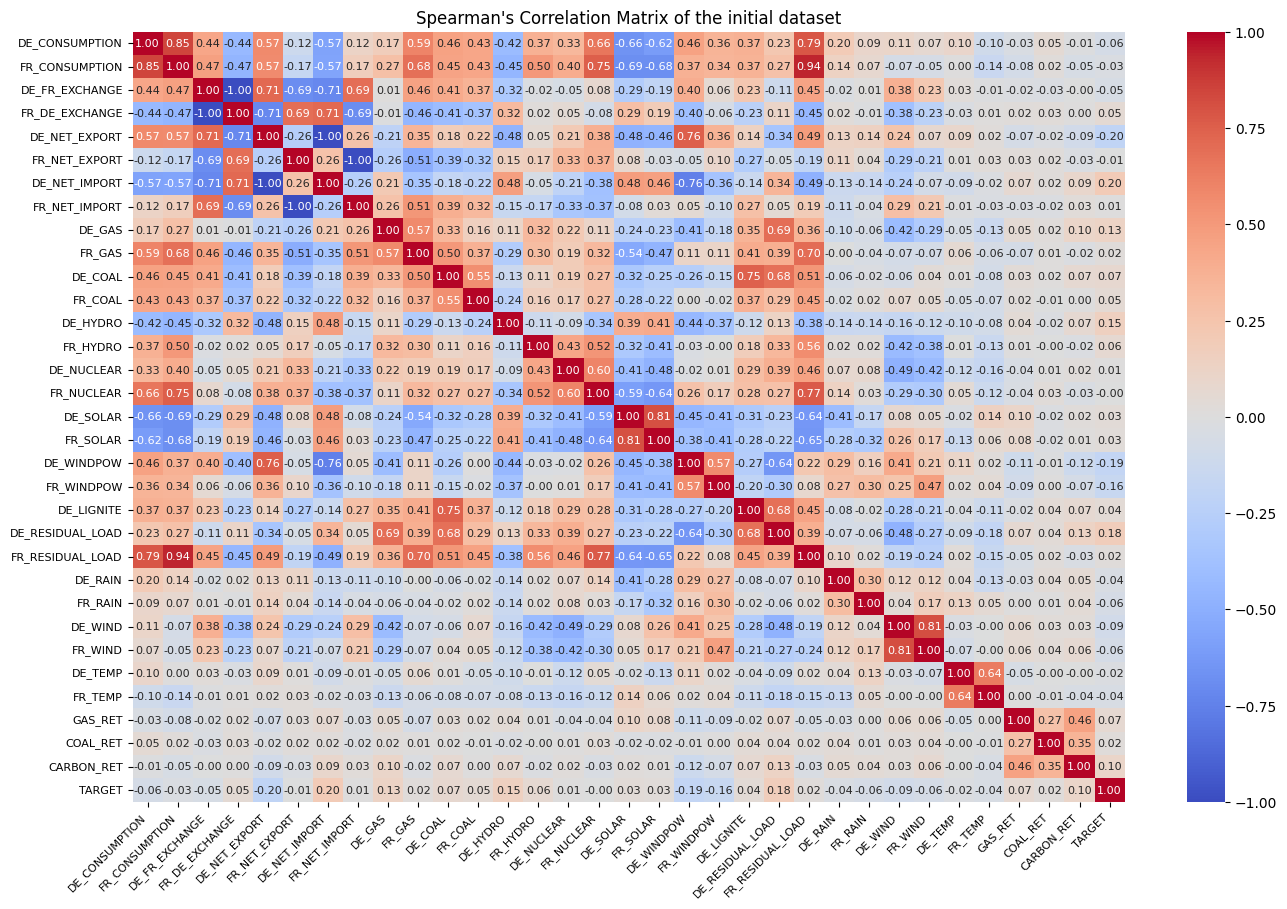

In [12]:
plt.figure(figsize=(16, 10))
df_cleaned = df.drop(columns=['ID', 'DAY_ID','COUNTRY'])
spearman_corr = df_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

By examining the **correlation matrices**, it is noticeable that the **Spearman** matrix shows stronger correlations with the '**TARGET**' row compared to the **Pearson** matrix. This difference arises because **Spearman** evaluates the **monotonic relationship** between variables, whether linear or not, based on their **ranks** rather than their absolute values. This method better captures relationships when the data is **nonlinear** or contains **outliers**, which might distort the **Pearson** correlation.


### Energy Production Distribution by Country

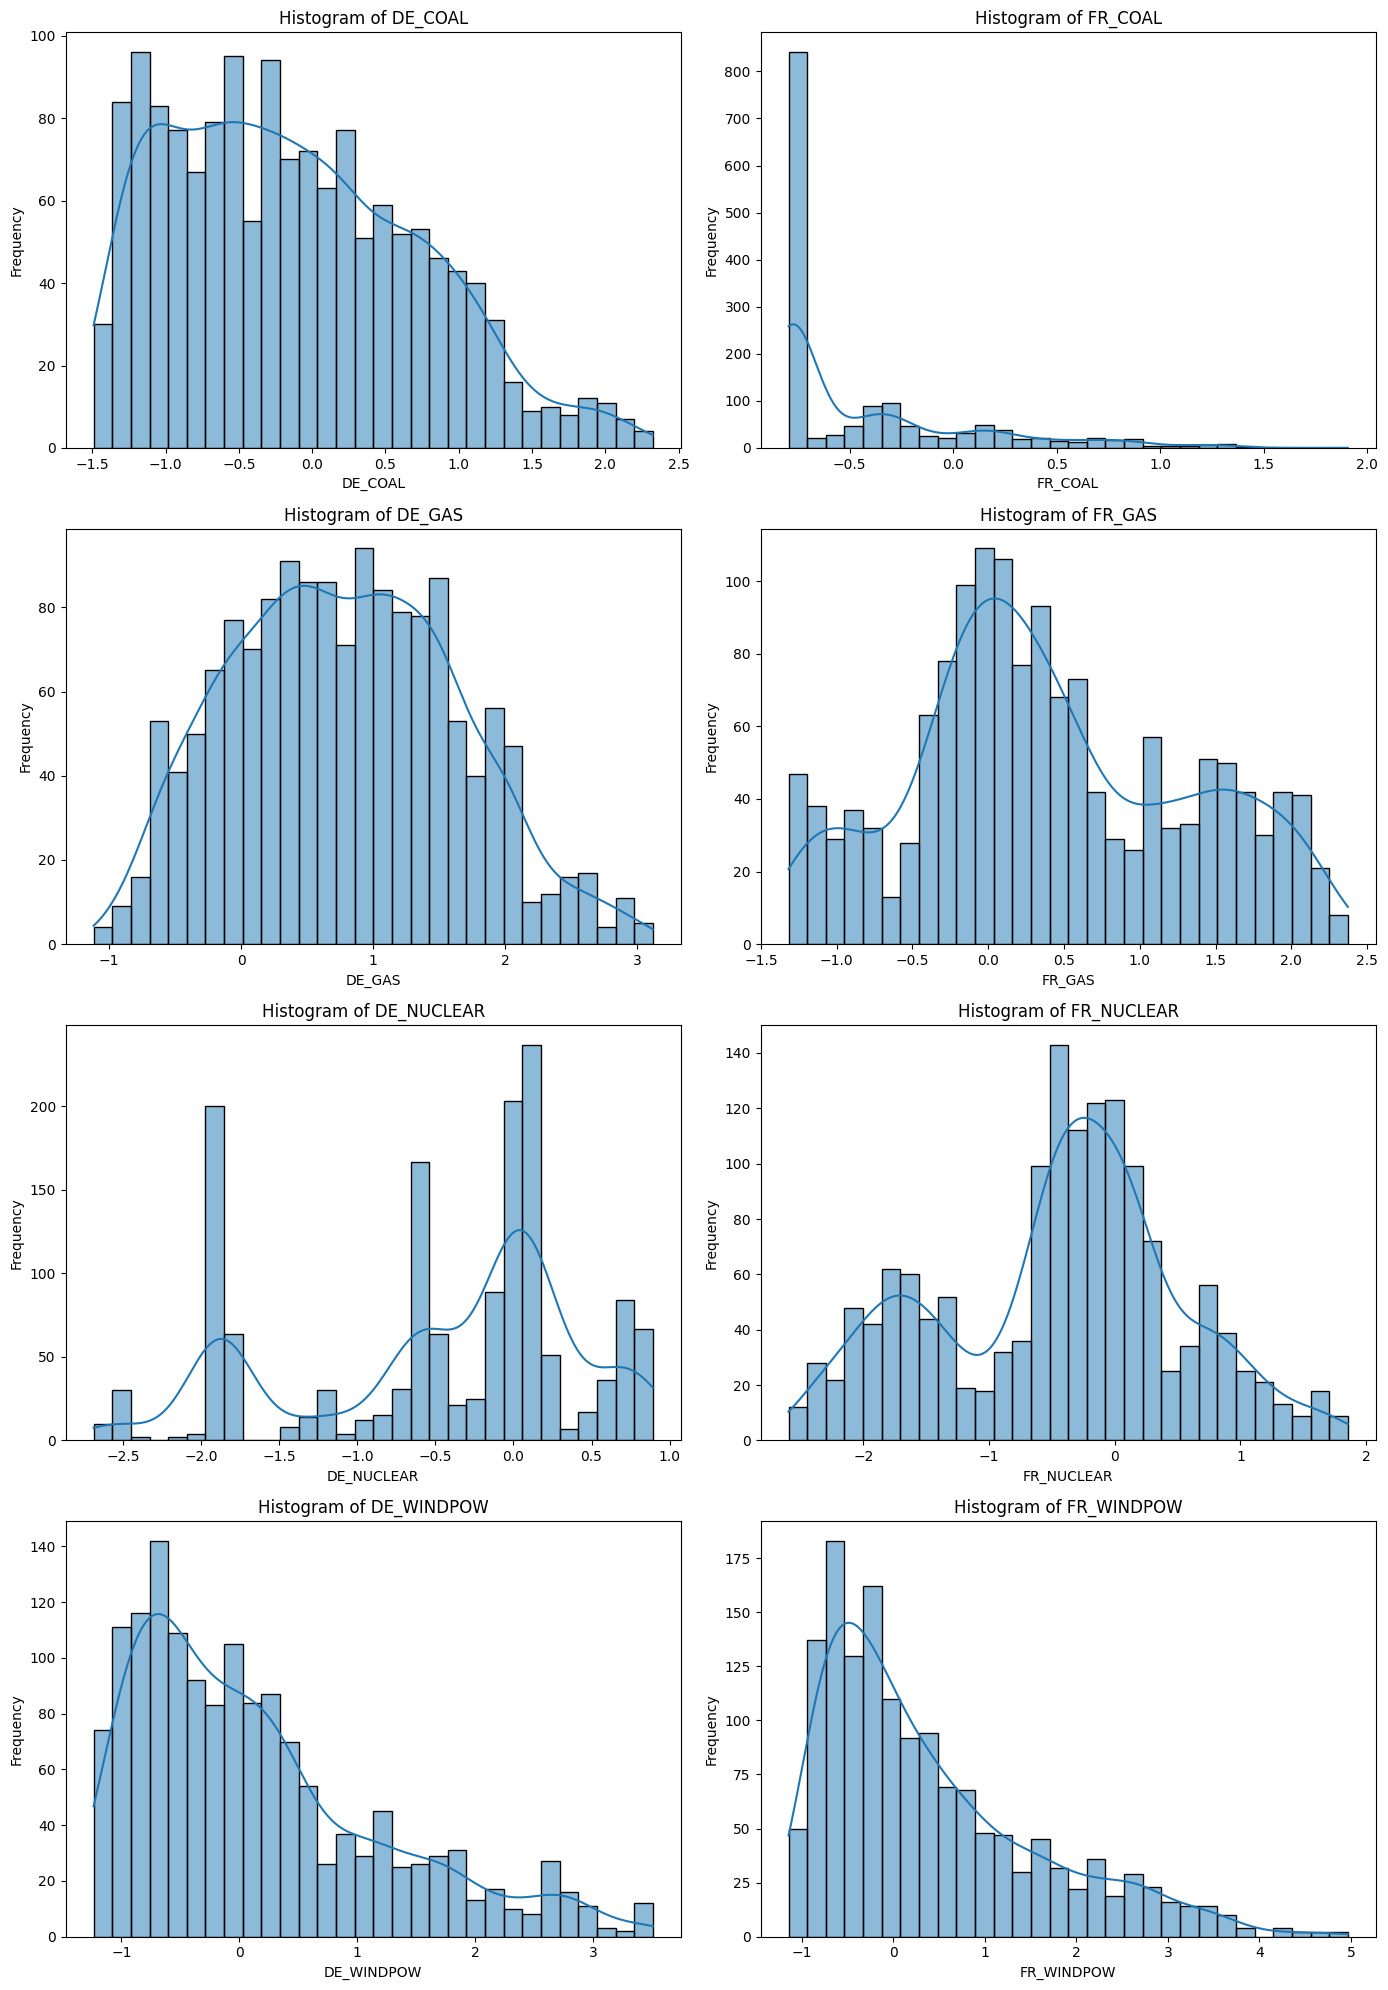

In [13]:
energy_sources = ['DE_COAL', 'FR_COAL', 'DE_GAS', 'FR_GAS', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_WINDPOW', 'FR_WINDPOW']

n_rows = len(energy_sources) // 2

plt.figure(figsize=(14, n_rows * 5))

for i, source in enumerate(energy_sources, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_general[source], bins=30, kde=True)
    plt.title(f'Histogram of {source}')
    plt.xlabel(source)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

These charts demonstrate that while certain energy sources, such as **wind power**, appear to be similarly distributed between **France** and **Germany**, the two countries clearly adopt **distinct energy strategies**. Notably, **France** stands out for its greater **stability** in **nuclear energy** production, while it remains relatively **weak** in terms of **coal** production.


### Spearman's Correlation Matrix for Data Related to France  

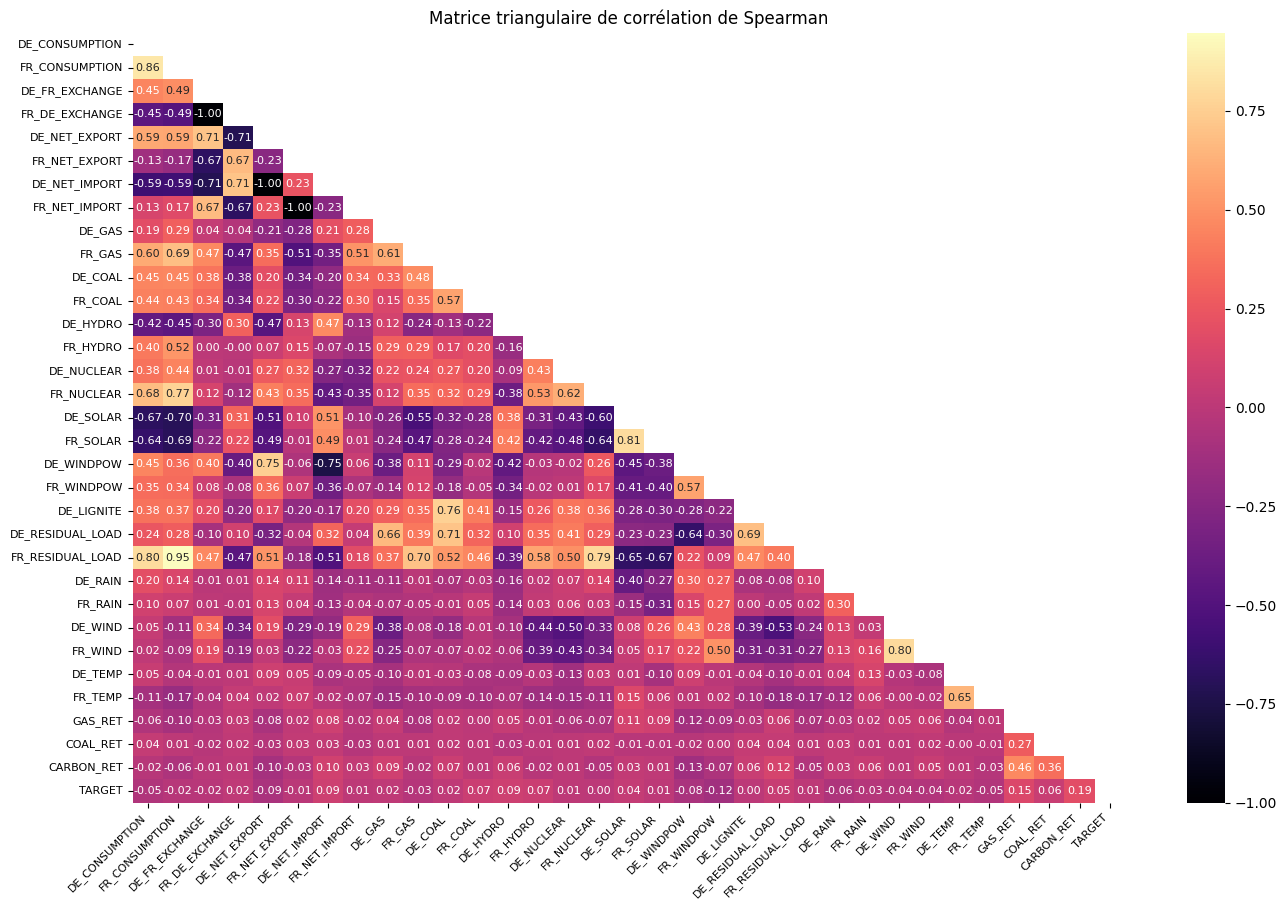

In [14]:
df_fr_cleaned=df_fr.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_fr_cleaned.corr()
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
spearman_corr = df_fr_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True,mask=mask, fmt=".2f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Spearman Correlation Matrix for Data Related to Germany 

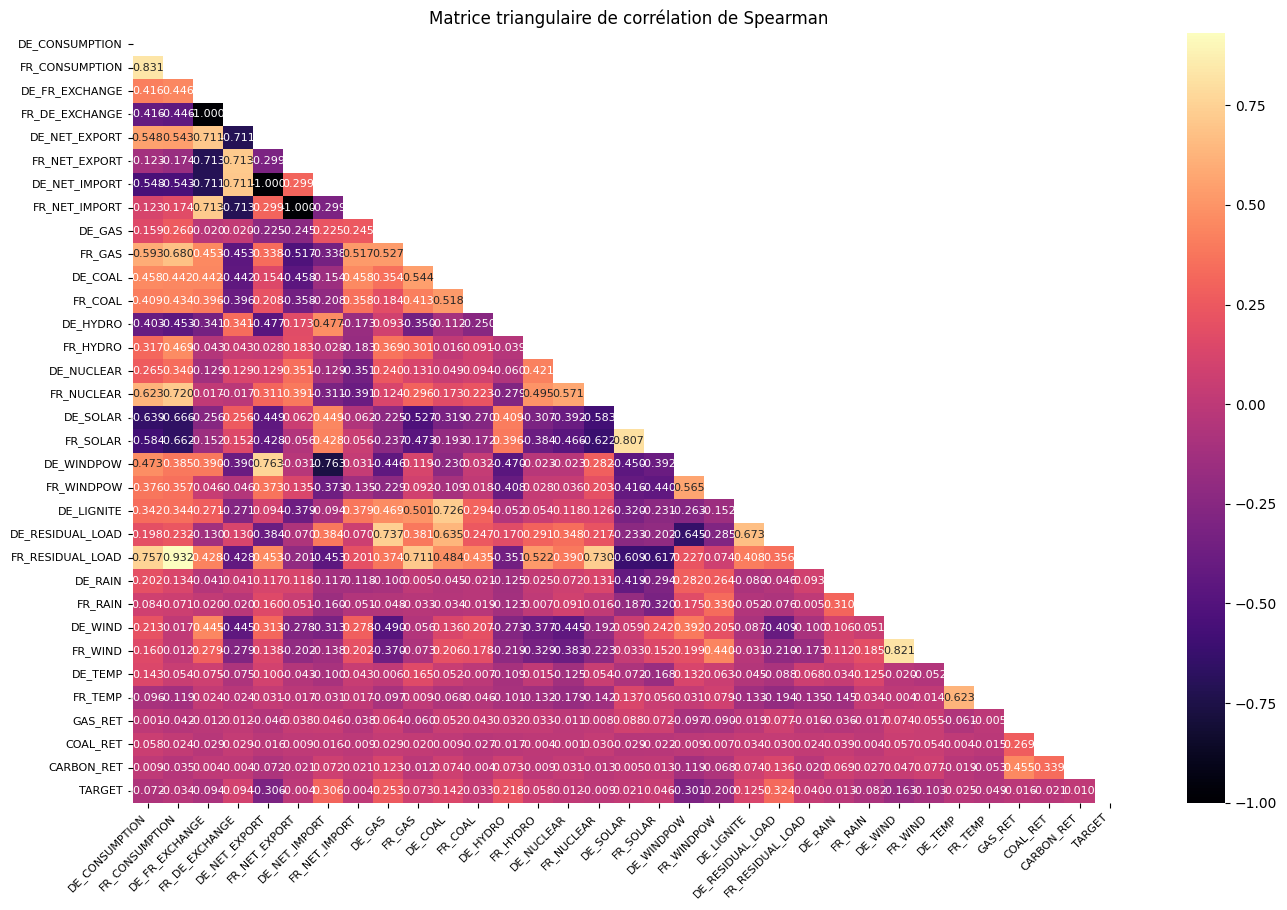

In [15]:
df_de_cleaned=df_de.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_de_cleaned.corr()
plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

spearman_corr = df_de_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr,mask=mask, annot=True, fmt=".3f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## II Model Evaluation

### Spearman's Correlation in Our Project

In this project, we aim to explain daily variations in electricity futures prices in Europe. Given the complex and non-linear relationships between factors like energy production, weather conditions, and market prices, **Spearman's correlation** is a suitable tool to evaluate our model's performance, alongside other metrics like R², MAE, and MSE.

### Why Use Spearman?

1. **Monotonicity**: The relationships between variables, such as the impact of gas prices on electricity prices, may be monotonic but non-linear. Spearman captures these monotonic trends where Pearson would fail.

2. **Robustness to Outliers**: Since the data can contain extreme values (e.g., sudden price spikes), Spearman is less sensitive to outliers, providing a more stable evaluation.

3. **Capturing Non-linear Relationships**: Variables like renewable energy production or electricity exchanges may have a non-linear effect. Spearman helps measure the monotonic relationship, even if it's not strictly linear.

### Spearman's Rank Correlation Formula

The Spearman rank correlation coefficient ($\rho$) is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:
- $d_i$ is the difference between the ranks of corresponding values in the two datasets.
- $n$ is the total number of data pairs.

### Additional Evaluation Metrics

- **R²**: This metric tells us the proportion of the variance in the target variable (electricity prices) explained by the model. A higher R² indicates a better fit.
  
- **MAE (Mean Absolute Error)**: This measures the average magnitude of errors in predictions, providing insight into how close the model's predictions are to the actual values, with smaller values being preferable.
  
- **MSE (Mean Squared Error)**: This gives us the squared average of the model's prediction errors, emphasizing larger errors more heavily. Like MAE, smaller values indicate better model performance.

Spearman's correlation is ideal for our project because it allows us to evaluate complex, non-linear trends in electricity prices while being robust to outliers. Alongside Spearman, we also use R², MAE, and MSE to provide a comprehensive view of our model's performance and ensure it captures the underlying dynamics of the electricity market effectively.


### K-Fold Cross-Validation and Model Evaluation

We use **k-fold cross-validation** to assess model performance on multiple data splits. The procedure involves:

1. **Data Preparation**: Features (`X`) and target (`y`) are separated from the dataset.
2. **K-Fold Cross-Validation**: Data is split into `k` folds, with each fold used for testing once.
3. **Standardization**: Features are scaled to have zero mean and unit variance using **StandardScaler**.
4. **Model Training**: The model is trained on the training data and predictions are made on the test set.
5. **Evaluation Metrics**: We calculate **Spearman's correlation**, **R²**, **MAE**, and **MSE** to assess model accuracy.
6. **Result Aggregation**: Metrics from each fold are collected in a DataFrame and returned.

This method provides a robust evaluation of the model’s performance across different subsets of data.


In [16]:
from sklearn.model_selection import KFold

def kfoldCrossValidation(df, M, k):
    X = df.drop(columns=['ID', 'TARGET'], errors='ignore')
    y = df['TARGET']

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    result = pd.DataFrame(columns=['Spearman', 'R2', 'MAE', 'MSE'])
  
    X = np.array(X)
    y = np.array(y)
  
    # Cross-validation loop
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]     
        y_train, y_test = y[train_index], y[test_index]

        # Convert arrays back to DataFrames
        X_train = pd.DataFrame(X_train, columns=df.drop(columns=['ID', 'TARGET'], errors='ignore').columns)
        X_test = pd.DataFrame(X_test, columns=df.drop(columns=['ID', 'TARGET'], errors='ignore').columns)
        
        # Appliquer la suppression des outliers uniquement sur X_train
        data_train = X_train.copy()
        data_train['TARGET'] = y_train  # Ajouter y_train pour synchronisation
        data_train = drop_extreme_outliers(data_train)  # Supprimer les outliers
        X_train = data_train.drop(columns=['TARGET'])
        y_train = data_train['TARGET']

        # Gestion des valeurs manquantes
        X_train = X_train.fillna(X_train.mean())
        X_test = X_test.fillna(X_train.mean())

        # Data Standardization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training and prediction   
        M.fit(X_train, y_train)
        y_pred_test = M.predict(X_test)
    
        # Metrics calculation
        result_temp = pd.DataFrame([{
            'Spearman': spearmanr(y_test, y_pred_test).correlation, 
            'R2': M.score(X_test, y_test), 
            'MAE': np.mean(np.abs(y_test - y_pred_test)), 
            'MSE': np.mean((y_test - y_pred_test) ** 2)
        }])
    
        if not result_temp.isna().all().all():  
            result = pd.concat([result, result_temp], ignore_index=True)
    
    return result, y_test, y_pred_test

## III Aggregation Model Function

Since we have separate models for each country, a function is required to aggregate the predictions from these two distinct machine learning models, each designed specifically to predict electricity prices in France and Germany. Each model is developed independently to account for the unique market dynamics, energy sources, and economic factors in each country.

### 1. Split the dataset by Country

The function split_dataset_by_country, which takes the original dataset as a parameter, enables splitting the dataset into two new datasets: df_fr (for the rows concerning France) and df_de (for the rows concerning Germany).

In [17]:
def split_dataset_by_country(df):
    df_fr = df[df['COUNTRY'] == 'FR']
    df_de = df[df['COUNTRY'] == 'DE']
    return df_fr, df_de

### 2. Drop irrelevent Columns

We decided, for each country (and thus for each model), to focus on the columns specifically related to each country. The function drop_irrelevant_columns allows us to remove the columns related to Germany from the df_fr dataset and the columns related to France from the df_de dataset.

In [18]:
def drop_irrelevant_columns(df, country):
    if country == 'FR':
        columns_to_drop = ['COUNTRY', 'DE_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_NET_EXPORT',
                           'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL', 'DE_HYDRO',
                           'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
                           'DE_RAIN', 'DE_WIND', 'DE_TEMP']
    elif country == 'DE':
        columns_to_drop = ['COUNTRY', 'FR_CONSUMPTION', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT',
                           'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL', 'FR_HYDRO',
                           'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
                           'FR_RAIN', 'FR_WIND', 'FR_TEMP']
        
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    return df.drop(columns=columns_to_drop)

### 3. Fill Missing Values & Drop Extreme Oultiers

Each dataset contains a certain number of missing values (as previously noted), and given the relatively limited amount of data, we couldn’t simply remove the rows with missing values. Therefore, we use the fill_missing_values function on df_fr and df_de individually to replace the missing values with the average of the column where the missing value is located here we can see with the plot that the data is already standardize so we can fill by 0.

In [19]:
def fill_missing_values(df):
    return df.fillna(0)

__To correctly predict non-outlier values in financial data, it is essential to remove extreme outliers that can heavily skew the model's performance and lead to inaccurate predictions.__ However, since financial datasets often contain numerous outliers that reflect genuine market behaviors, removing all of them would risk losing valuable information. Instead, a balanced approach is needed, such as capping extreme values to mitigate their impact while preserving the dataset's integrity and predictive power.

In [20]:
def drop_extreme_outliers(df,threshold=5):
    for column in df.select_dtypes(include=['number']).columns:  # Only process numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)] 
    return df

### 4. Merging the results

Although we trained models and made predictions separately for France and Germany, the final model to submit at the end of the challenge is a single model. The function combine_results allows us to test the previous metrics, but this time on the entire set of our predictions.

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de):
    y_pred_fr = pd.Series(y_pred_fr)
    y_pred_de = pd.Series(y_pred_de)
    y_test_de = pd.Series(y_test_de)
    y_test_fr = pd.Series(y_test_fr)
    
    y_true_combined = pd.concat([y_test_fr, y_test_de], axis=0)
    y_pred_combined = pd.concat([pd.Series(y_pred_fr), pd.Series(y_pred_de)], axis=0)
    combined_r2 = r2_score(y_true_combined, y_pred_combined)
    combined_mse = mean_squared_error(y_true_combined, y_pred_combined)
    combined_spearman = spearmanr(y_true_combined, y_pred_combined).correlation
    combined_mae = np.mean(np.abs(y_true_combined - y_pred_combined))   
    return combined_r2, combined_mse, combined_mae, combined_spearman

### 5. Final Function

Finally, we implement our global function, which sequentially utilizes the previously defined functions (1 to 4). This function provides the model's performance metrics for France, Germany, and the entire dataset.

The parameters "FeatureEngineering" and "DropIrrelevantColumns" will be applied later, and we will provide an explanation at that time.

In [22]:
def Final_model(df, model_fr, model_de,FeatureEngineering=None, DropIrrelevantColumns=True):

    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)

    if FeatureEngineering is None:
        if DropIrrelevantColumns: 
            df_fr = drop_irrelevant_columns(df_fr, 'FR')
            df_de = drop_irrelevant_columns(df_de, 'DE')
        else:
            df_fr = df_fr.drop(columns=['COUNTRY'])
            df_de = df_de.drop(columns=['COUNTRY'])

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])
        df_fr, df_de = FeatureEngineering(df_fr,df_de)
    

    result_fr, y_test_fr, y_pred_fr = kfoldCrossValidation(df_fr, model_fr, 6)
    result_de, y_test_de, y_pred_de = kfoldCrossValidation(df_de, model_de, 6)

    # Step 2 : Combining the results and evaluating
    combined_r2, combined_mse, combined_mae, combined_spearman = combine_results(y_test_fr, y_pred_fr, y_test_de, y_pred_de)
    result_global = pd.DataFrame([{
        'R2': combined_r2,
        'MSE': combined_mse,
        'MAE': combined_mae,
        'Spearman': combined_spearman
    }])

    return result_fr, result_de, result_global

## IV First Model Using Linear Regression

### Model only with country separation

Building on our prior efforts, it’s now straightforward to test and evaluate different models.

Training of a model using simple LinearRegression

In [23]:
result_basic = Final_model(df, LinearRegression(), LinearRegression(), DropIrrelevantColumns=False)
result_basic[2]

,R2,MSE,MAE,Spearman
0,0.025082,1.510558,0.652482,0.274811


We observe that our Spearman correlation, R², and MSE scores are relatively low. However, it's crucial to consider the context. In financial markets, price movements are influenced by thousands of factors with complex, non-linear relationships, making it nearly impossible to develop a model that fully explains electricity prices today. For reference, the best model from the ENS QRT challenge addressing this problem achieved a Spearman correlation of 0.6. Our objective is to enhance these evaluation metrics as much as possible. __Here we can see that the result improved from 0,21 to 0,26 for the Spearman score with the previous stage, this is because we correctly handled extreme outliers__

Display the results by country:

In [24]:
print("Results for France:")
print(result_basic[0],"\n")
print("Mean results for France:")
result_basic[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0  0.074876 -0.016886  0.515754  1.265420
1  0.086202 -0.019918  0.566957  1.035484
2  0.165269 -0.006054  0.362450  0.560063
3  0.062782 -0.035478  0.462175  0.767118
4  0.167369 -0.004827  0.576361  1.139022
5  0.294028  0.009576  0.627497  1.549880 

Mean results for France:


Spearman    0.141754
R2         -0.012264
MAE         0.518532
MSE         1.052831
dtype: float64

In [25]:
print("Results for Germany:")
print(result_basic[1],"\n")
print("Mean results for Germany:")
result_basic[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.409672  0.029714  0.585345  1.031623
1  0.211730 -0.000434  0.647757  1.116345
2  0.417132  0.065793  0.552436  0.696374
3  0.342532  0.073790  0.593276  0.861056
4  0.361145  0.040885  0.683702  1.126501
5  0.333657  0.045255  0.685406  1.458742 

Mean results for Germany:


Spearman    0.345978
R2          0.042500
MAE         0.624654
MSE         1.048440
dtype: float64

As observed previously, it comes as no surprise that the German model outperforms the French one. This aligns with our earlier findings, where the features in the German dataset exhibited higher Spearman and Pearson correlation scores compared to those in the French dataset. Consequently, our model demonstrates better performance in Germany than in France.

### Model with separation and deleting of useless column for each country

Next, we explore whether the model's performance improves when features specific to France are removed for the German model, and vice versa. This is accomplished using the `DropIrrelevantColumns` function, which handles the removal of these features.

In [26]:
result = Final_model(df,LinearRegression(), LinearRegression(), DropIrrelevantColumns=True)
print("Results for the overall data:")
result[2]

Results for the overall data:


,R2,MSE,MAE,Spearman
0,0.029892,1.503106,0.643469,0.274672


We observe a slightly improved score after applying this approach, so we will retain it for the remainder of the project.

Results for each Country

In [27]:
print("Results for France:")
print(result[0],"\n")
print("Mean results for France:")
result[0].mean()

Results for France:
   Spearman        R2       MAE       MSE
0  0.177589  0.009883  0.495437  1.232108
1  0.046533 -0.032119  0.563910  1.047872
2  0.147612 -0.038210  0.363607  0.577964
3  0.075787 -0.027963  0.446527  0.761550
4  0.195354  0.014810  0.555278  1.116763
5  0.269440  0.011483  0.607215  1.546896 

Mean results for France:


Spearman    0.152053
R2         -0.010353
MAE         0.505329
MSE         1.047192
dtype: float64

In [28]:
print("Results for Germany:")
print(result[1],"\n")
print("Mean results for Germany:")
result[1].mean()

Results for Germany:
   Spearman        R2       MAE       MSE
0  0.420027  0.059003  0.569384  1.000482
1  0.240698  0.036331  0.629511  1.075320
2  0.397676  0.058541  0.556171  0.701780
3  0.336635  0.092208  0.584909  0.843934
4  0.392729  0.058964  0.674143  1.105267
5  0.353054  0.053987  0.691243  1.445400 

Mean results for Germany:


Spearman    0.356803
R2          0.059839
MAE         0.617560
MSE         1.028697
dtype: float64

## V Feature engineering

We want to add more columns to create more precise models so we will do some feature engineering 

We can add column specific with this domain area such as energy ratios, weather effects, and clustering, wich will provide further insights into underlying patterns. Weather effects, such as temperature or wind, are crucial in energy demand prediction, as they directly influence consumption and production.

In [29]:
# Function to add energy source ratios and effects
def add_energy(df):
    energy_sources = ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']
    
    for country in ['DE_', 'FR_']:
        total_energy = sum(df[f'{country}{source}'] for source in energy_sources)
        
        for source in energy_sources:
            df[f'{country}{source}_RATIO'] = df[f'{country}{source}'] / total_energy

        df[f'{country}WIND_SOLAR'] = df[f'{country}WINDPOW'] + df[f'{country}SOLAR']# energies that comes from nature
        df[f'{country}TEMP_EFFECT'] = df[f'{country}TEMP'] * df[f'{country}CONSUMPTION']# temp can have effect on the consumption
        df[f'{country}WIND_EFFECT'] = df[f'{country}WIND'] * df[f'{country}WINDPOW']# wind can have effect on windpower
        df[f'{country}SOLAR_EFFECT'] = df[f'{country}SOLAR'] * df[f'{country}TEMP']# solar power can have effect on temperature
    
    return df

The following function calculates the correlation matrix and selects features that are either highly correlated with each other or have low correlation with the target variable. It combines both conditions to decide which features to drop

In [30]:
def select_features_based_on_correlation(df, target_column, multicollinear_threshold, correlation_threshold):
    # Calculate the Spearman correlation matrix because it is the metric that we choose
    corr_matrix=df.corr(method='spearman')
    # Identify columns that are highly correlated with each other
    # (excluding the target variable correlation)
    high_corr_var=np.where(corr_matrix > multicollinear_threshold)
    high_corr_var=[(corr_matrix.index[x], corr_matrix.columns[y]) 
                     for x, y in zip(*high_corr_var) 
                     if x!=y and x < y]
    # Extract the names of columns to drop based on multicollinearity
    multicollinear_features=set([item for sublist in high_corr_var for item in sublist])
    # Identify features that have a low correlation with the target variable
    low_corr_with_target=corr_matrix[target_column][abs(corr_matrix[target_column]) < correlation_threshold].index.tolist()
    # Combine features to drop due to multicollinearity and low correlation with target
    features_to_drop=multicollinear_features.union(low_corr_with_target)
    # Determine the final list of features to keep
    features_to_keep=[feature for feature in df.columns if feature not in features_to_drop and feature!=target_column]
    
    return features_to_keep

Here, we filter the dataset for France (COUNTRY == 'FR'), remove certain columns, and keep some of the original columns, which can still have an impact on our prediction even if they are less correlated than the ‘artificial’ columns from feature engineering.

### Final function that will be used for the feature engineering

In [31]:
def FeatureEngineering(df_fr, df_de, df_fr_test=None, df_de_test=None):
    # Retain columns in the main dataset based on correlation with TARGET
    col_fr_best = select_features_based_on_correlation(df_fr, 'TARGET', 0.93, 0.02)

    # Select columns that do not start with 'DE' (avoid mixing German data)
    df_no_de = df_fr[df_fr.columns[~df_fr.columns.str.startswith('DE')]]
    col_fr = [col for col in df_no_de.columns if col in col_fr_best]
    df_fr.fillna(df_fr.mean(), inplace=True)
    df_fr_test.fillna(df_fr_test.mean(), inplace=True) if df_fr_test is not None else None

    # Retain columns in the German dataset based on correlation with TARGET
    col_de_best = select_features_based_on_correlation(df_de, 'TARGET', 0.93, 0.03)

    # Select columns that do not start with 'FR' (avoid mixing French data)
    df_no_fr = df_de[df_de.columns[~df_de.columns.str.startswith('FR')]]
    col_de = [col for col in df_no_fr.columns if col in col_de_best]
    df_de.fillna(df_de.mean(), inplace=True)
    df_de_test.fillna(df_de_test.mean(), inplace=True) if df_de_test is not None else None

    original_fr = df_fr[col_fr]
    original_de = df_de[col_de]

    # Apply feature engineering
    df_fr = add_energy(df_fr)
    df_de = add_energy(df_de)

    if df_fr_test is not None:
        original_fr_test = df_fr_test[col_fr]
        df_fr_test = add_columns(df_fr_test)

    if df_de_test is not None:
        original_de_test = df_de_test[col_de]
        df_de_test = add_columns(df_de_test)

    # Select the best columns based on correlation
    # Features of fr are less correlated with target so in order to have only the best features we will have a different threshold
    best_features_fr = select_features_based_on_correlation(df_fr, 'TARGET', 0.93, 0.15)
    best_features_de = select_features_based_on_correlation(df_de, 'TARGET', 0.93, 0.2)

    # Concatenate and remove duplicate columns
    df_fr = pd.concat([original_fr, df_fr[best_features_fr + ['TARGET']]], axis=1)
    df_fr = df_fr.loc[:, ~df_fr.columns.duplicated()]  # Remove duplicate columns

    df_de = pd.concat([original_de, df_de[best_features_de + ['TARGET']]], axis=1)
    df_de = df_de.loc[:, ~df_de.columns.duplicated()]  # Remove duplicate columns

    if df_fr_test is not None:
        df_fr_test = pd.concat([original_fr_test, df_fr_test[best_features_fr]], axis=1)
        df_fr_test = df_fr_test.loc[:, ~df_fr_test.columns.duplicated()]  # Remove duplicate columns

    if df_de_test is not None:
        df_de_test = pd.concat([original_de_test, df_de_test[best_features_de]], axis=1)
        df_de_test = df_de_test.loc[:, ~df_de_test.columns.duplicated()]  # Remove duplicate columns

    if df_fr_test is not None and df_de_test is not None:
        return df_fr, df_de, df_fr_test, df_de_test
    else:
        return df_fr, df_de

## VI Model Using LinearRegression and Feature Engineering

#### Linear Regression

In [32]:
result = Final_model(df,LinearRegression(), LinearRegression(),FeatureEngineering, DropIrrelevantColumns=True)
result[2]

,R2,MSE,MAE,Spearman
0,0.031415,1.500745,0.631982,0.295073


__The Speaman Correlation improved a lot with the Feature Engineering from 0,275 to 0,295 so we will use it in our our evaluation of the best model__
\
The R^2 score also improved with this approach

In [33]:
result[0].mean()

Spearman    0.183273
R2         -0.006368
MAE         0.499220
MSE         1.044201
dtype: float64

In [34]:
result[1].mean()

Spearman    0.380734
R2          0.076717
MAE         0.601515
MSE         1.012217
dtype: float64

## VII Testing other models

__The goal is now to test various machine learning models, whether covered in class or not, to refine our model and identify the most effective approach to enhance our evaluation metrics.\
We are first going to create a function get_best_grid_parameters which will allow us, for each model we want to test, to indicate the best hyperparameters to retain for the French dataset and the German dataset separately__

### GridSearchCV function

**Purpose of this function**:
It performs hyperparameter tuning using `GridSearchCV` on financial datasets split by country (France and Germany). It identifies the best parameters for the model while addressing challenges like outliers and missing data.
- 1. Splits data into France and Germany subsets using `split_dataset_by_country`.
- 2. Optionally applies custom transformations or drops irrelevant columns.
- 3. Replaces missing values with `0` to ensure complete datasets.
- 4. Sets up `GridSearchCV` with `neg_mean_absolute_error` scoring for both datasets.
- 5. Splits data into 80% training and 20% testing sets.
- 6. Removes extreme outliers to reduce noise while preserving essential data.
- 7. Fits separate grid searches for France and Germany datasets.
- 8. Evaluates models on `R2`, `MAE`, `MSE`, and Spearman correlation.
- 9. Prints metrics and best hyperparameters for both countries.
- 10. Returns the best parameter sets.

It will optimizes hyperparameters for country-specific data, handles outliers and missing values effectively, automates grid search for systematic tuning and finally provides a comprehensive performance evaluation.

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
import pandas as pd

def get_best_grid_parameters(data,model,parametre, FeatureEngineering=None, DropIrrelevantColumns=True):

    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(data)

    #Step 2 : we apply FeatureEnginnering or not
    if FeatureEngineering is None:
        if DropIrrelevantColumns: 
            df_fr = drop_irrelevant_columns(df_fr, 'FR')
            df_de = drop_irrelevant_columns(df_de, 'DE')
        else:
            df_fr = df_fr.drop(columns=['COUNTRY'])
            df_de = df_de.drop(columns=['COUNTRY'])

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])
        df_fr, df_de = FeatureEngineering(df_fr,df_de)

    # Step 3 : Missing values replacement
    df_fr = df_fr.fillna(0)
    df_de = df_de.fillna(0)

    #Step 4 : initialisation of grid search
    grid1= GridSearchCV(estimator=model, param_grid=parametre, cv=5, n_jobs=1, scoring='neg_mean_absolute_error')
    grid2= GridSearchCV(estimator=model, param_grid=parametre, cv=5, n_jobs=1, scoring='neg_mean_absolute_error')
    
    X_fr=df_fr.drop('TARGET', axis=1)
    X_de=df_de.drop('TARGET', axis=1)
    y_fr=df_fr['TARGET']
    y_de=df_de['TARGET']
    
    X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_fr, y_fr, test_size=0.2, random_state=42)
    X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(X_de, y_de, test_size=0.2, random_state=42)

    #Step 5 : We drop extreme outliers
    data_train_fr = X_train_fr.copy()
    data_train_fr['TARGET'] = y_train_fr
    data_train_fr = drop_extreme_outliers(data_train_fr)
    
    X_train_fr = data_train_fr.drop(columns=['TARGET'])
    y_train_fr = data_train_fr['TARGET']
    
    data_train_de = X_train_de.copy()
    data_train_de['TARGET'] = y_train_de
    data_train_de = drop_extreme_outliers(data_train_de)
    
    X_train_de = data_train_de.drop(columns=['TARGET'])
    y_train_de = data_train_de['TARGET']

    #Step 6 : fitting grid searchs
    grid1.fit(X_train_fr,y_train_fr)
    grid2.fit(X_train_de,y_train_de)

    #Step 7 : We compute metrics for France and Germany
    y_pred_fr = grid1.predict(X_test_fr)
    r2_fr = r2_score(y_test_fr, y_pred_fr)
    mae_fr = mean_absolute_error(y_test_fr, y_pred_fr)
    mse_fr = mean_squared_error(y_test_fr, y_pred_fr)
    spearman_fr, _ = spearmanr(y_test_fr, y_pred_fr)

    y_pred_de = grid2.predict(X_test_de)
    r2_de = r2_score(y_test_de, y_pred_de)
    mae_de = mean_absolute_error(y_test_de, y_pred_de)
    mse_de = mean_squared_error(y_test_de, y_pred_de)
    spearman_de, _ = spearmanr(y_test_de, y_pred_de)

    # We print the metrics fo both models
    print("Metrics for France:")
    print(f"R2: {r2_fr}")
    print(f"MAE: {mae_fr}")
    print(f"MSE: {mse_fr}")
    print(f"Spearman: {spearman_fr}")
    print()

    print("Metrics for Germany:")
    print(f"R2: {r2_de}")
    print(f"MAE: {mae_de}")
    print(f"MSE: {mse_de}")
    print(f"Spearman: {spearman_de}")
    print("France Best Parameters : ",grid1.best_params_)
    print("Germany Best Parameters : ", grid2.best_params_)
    

    #We return the best parameters
    return grid1.best_params_, grid2.best_params_
    

__We are now going to test each model with different hyperparameters and rely on gridsearch to select the best ones, finaly leading us to be able to determine which one provides the best results for the French dataset and the German one.__
\
\
__List of possible models to try :__
__1. Random Forest\
2. Polynomial Regression\
3. Gradient Boosting\
4. XG Boost\
5. Light GBM\
6. KNN Regressor\
7. SVR\
8. Adaboost__

### 1. Random Forest

Let's experiment with the **RandomForestRegressor**, which is highly effective for capturing non-linear relationships. To maximize its potential, we use **GridSearchCV**, a technique that systematically tests multiple combinations of hyperparameters for the Random Forest and selects the best configuration for our model.

Moving forward, we plan to improve the model’s performance by fine-tuning the **RandomForestRegressor** and optimizing feature engineering specifically tailored to this model. These enhancements are expected to further reinforce its advantage over Linear Regression, particularly in terms of Spearman Correlation, by fully leveraging its ability to capture non-linear relationships between variables and the target. Additionally, we intend to investigate more advanced and sophisticated models to drive further gains in predictive accuracy and overall performance.

In [36]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [10,15],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,4],
}
rf = RandomForestRegressor(random_state=42)

grid1_params,grid2_params  = get_best_grid_parameters(df, rf, param_grid, FeatureEngineering,DropIrrelevantColumns=True)

KeyboardInterrupt: 

__The best hyperparameters are not the same for each model: the model appears to perform better with a smaller tree depth (which helps prevent overfitting in our dataset with limited dimensions). It also benefits from a larger number of trees for Germany but not for France : while this increases computation time, it makes the estimates more robust. The high value for min_samples_split for France suggests a model that prefers moderate complexity. Finally, requiring at least 4 samples in each leaf provides regularization.__

The **RandomForestRegressor** demonstrates a markedly higher Spearman Correlation score compared to **Linear Regression**, highlighting but only on  the french dataset its enhanced ability to capture relationships within the data. Additionally, it achieves a notable improvement in the **R² score** (0.012 versus a negative one), further underscoring its effectiveness. These metrics indicate that the RandomForestRegressor is better equipped to capture underlying patterns, particularly non-linear relationships. The model’s higher R² reflect its superior capacity to explain variance in the data and deliver more accurate predictions. This performance emphasizes the advantages of employing a non-linear model like Random Forest, showcasing its robustness in predictive power and generalization.

In [ ]:
rf_fr = RandomForestRegressor(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)
Final_model(df,rf_fr,LinearRegression(),FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.264402  0.014111  0.496892  1.226846
 1  0.027861 -0.025799  0.569818  1.041455
 2  0.117062 -0.062516  0.373736  0.591495
 3  0.218585 -0.010991  0.435875  0.748977
 4  0.217207  0.017976  0.565857  1.113174
 5  0.264303  0.026109  0.602790  1.524008,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.041256  1.485498  0.632368  0.285838)

### 2. Polynomial Regression

Polynomial regression allows for modeling non-linear relationships by introducing polynomial terms to the linear regression model. This makes it capable of capturing more complex patterns in the data without needing complex algorithms. It's simple to implement and interpret, especially when the underlying relationship is polynomial in nature.
\
\
__However, polynomial regression is prone to overfitting, especially when the degree of the polynomial is too high wich is not good here. As the degree increases, the model may fit noise rather than actual trends, leading to poor generalization on new data.__

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('poly_features', PolynomialFeatures()),('linear_regression', LinearRegression())])

param_grid = {'poly_features__degree': [1, 2, 3, 4, 5],  # polynome degree
             }

grid1_params,grid2_params = get_best_grid_parameters(df,pipeline, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.00505879334072723
MAE: 0.5508003774972666
MSE: 1.402816668108724
Spearman: 0.16288679463774902

Metrics for Germany:
R2: 0.03887419702373951
MAE: 0.5632796035460443
MSE: 0.9158934740920973
Spearman: 0.38460420393559935
France Best Parameters :  {'poly_features__degree': 1}
Germany Best Parameters :  {'poly_features__degree': 1}


__After testing with different polynomial degrees, a degree of 1 appears to be the most effective, which corresponds to a basic linear regression. Adding complexity does not improve the model's performance, likely due to the dataset's limited dimensionality. However, the result is not significant enough to conclude that the relationships between variables are non-linear.__


A polynomial regression with degree 1 is mathematically equivalent to linear regression, as it models the data using a single linear relationship between the input and output variables. 

In [ ]:
model_fr = Pipeline([
    ('poly_features', PolynomialFeatures(degree=grid1_params['poly_features__degree'])),
    ('linear_regression', LinearRegression())
])

model_de = Pipeline([
    ('poly_features', PolynomialFeatures(degree=grid2_params['poly_features__degree'])),
    ('linear_regression', LinearRegression())
])

Final_model(df,model_fr,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.200750  0.003722  0.491517  1.239775
 1  0.070527 -0.021104  0.556291  1.036688
 2  0.126207 -0.033671  0.357469  0.575438
 3  0.151644 -0.019138  0.439867  0.755013
 4  0.249424  0.023010  0.548062  1.107467
 5  0.301083  0.008972  0.602112  1.550825,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.031415  1.500745  0.631982  0.295073)

### 3. Gradient Boosting

Gradient boosting is a powerful ensemble learning method that builds strong predictive models by combining weak learners (typically decision trees). __It is effective in handling various types of data, including imbalanced data, and typically provides high accuracy and robustness to overfitting when properly tuned__. It can capture complex non-linear relationships and interactions between features.
\
\
However Gradient boosting can be computationally expensive and slower to train compared to simpler models. It also requires careful tuning of hyperparameters, such as the learning rate and number of estimators, to avoid overfitting or underfitting.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50,200],  # Nombre d'arbres dans la forêt
    'max_depth': [3, 5, 10],  # Profondeur maximale des arbres
    'learning_rate': [0.01,0.1, 0.5],  # Taux d'apprentissage (très petit vs fort)
    'subsample': [0.2,0.4,0.6],
}

gb_regressor = GradientBoostingRegressor(random_state=42)

grid1_params,grid2_params = get_best_grid_parameters(df,gb_regressor, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.008948230758684117
MAE: 0.5511582478829337
MSE: 1.397332758503858
Spearman: 0.1473541979914537

Metrics for Germany:
R2: -0.0021516059905160034
MAE: 0.5671439667812535
MSE: 0.9549885281774081
Spearman: 0.3164444270525607
France Best Parameters :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
Germany Best Parameters :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}


__The hyperparameters for both France and Germany suggest that the model favors a lower learning rate, indicating a preference for slow, gradual learning rather than aggressively fitting the data. The globally small optimal depth and subsample size imply that the model is attempting to combat overfitting, particularly given the dataset's size (although the German dataset tolerates slightly higher nb of estimatiors). Additionally, adding a large number of trees does not significantly enhance the model's overall performance, suggesting that increasing complexity beyond a certain point does not yield better results.__

These results reflect key principles of gradient boosting: a lower learning rate prevents overfitting by refining predictions incrementally, while limiting tree depth and using subsampling control complexity and enhance generalization through diverse trees.

In [ ]:
model_fr = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=50,
    subsample=0.6
)

Final_model(df,model_fr,LinearRegression(),FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.268442  0.009933  0.492794  1.232046
 1  0.066682 -0.006982  0.538257  1.022351
 2  0.108588 -0.026081  0.347219  0.571212
 3  0.150231 -0.010805  0.434071  0.748839
 4  0.292401  0.012388  0.547410  1.119508
 5  0.288619 -0.008307  0.609628  1.577865,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.021493  1.516118  0.636255  0.276863)

### 4. XG Boost

XGBoost is an optimized version of gradient boosting, designed to be faster and more efficient. It features regularization to prevent overfitting, and it handles missing values naturally. XGBoost often performs very well in competitive machine learning tasks and is highly flexible.
\
\
__However like gradient boosting, XGBoost can be prone to overfitting if not tuned properly and our challenge will be to face this__. Although faster than traditional gradient boosting, it still requires considerable computational resources for large datasets, and tuning hyperparameters can be complex.

In [ ]:
from xgboost import XGBRegressor

param_grid = {
        'max_depth': [3, 6, 10], 
        'reg_alpha': [0.1, 0.2, 0.3],  
        'n_estimators': [100],  
        'learning_rate': [0.05, 0.1, 0.2], 
        'colsample_bytree': [0.6, 0.8, 0.9],  
        'subsample': [0.6, 0.8, 0.9]
}

xgb_regressor = XGBRegressor(random_state=42)

grid1_params,grid2_params = get_best_grid_parameters(df,xgb_regressor, param_grid, FeatureEngineering,DropIrrelevantColumns=True)


Metrics for France:
R2: -0.002394779945238623
MAE: 0.552669305450398
MSE: 1.4133258286224704
Spearman: 0.16878115101951285

Metrics for Germany:
R2: 0.0006353074587061025
MAE: 0.5749378682852186
MSE: 0.9523327719453957
Spearman: 0.28774038461538465
France Best Parameters :  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.3, 'subsample': 0.9}
Germany Best Parameters :  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.2, 'subsample': 0.6}


__In both cases, the maximum depth is limited, suggesting a controlled complexity and a focus on preventing overfitting, especially given the reduced dataset size. The learning rate is very low, indicating that the model prefers to adjust gradually, even if it increases computation time. While the number of trees is moderate, each one uses only 60% of the available features, which helps avoid overfitting. The subsample parameter further regularizes the model by training each tree on only 60 to 90% of the data. Finally, the models favor a moderate but not too low reg_alpha penalty, highlighting its necessity__

These choices align with regularization principles to enhance generalization, crucial for smaller datasets where overfitting is more likely.

In [ ]:
model_fr = XGBRegressor(
    max_depth=3,
    reg_alpha=0.3,
    n_estimators=100,
    learning_rate=0.05,
    colsample_bytree=0.6,
    subsample=0.9
)

model_de = XGBRegressor(
    max_depth=3,
    reg_alpha=0.2,
    n_estimators=100,
    learning_rate=0.05,
    colsample_bytree=0.6,
    subsample=0.6
)

Final_model(df,model_fr,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.236392 -0.018945  0.493503  1.267982
 1  0.085100 -0.022419  0.563885  1.038024
 2  0.055401 -0.097795  0.379238  0.611135
 3  0.120423 -0.031258  0.450027  0.763991
 4  0.264039  0.028192  0.560197  1.101593
 5  0.184287  0.002063  0.613890  1.561637,
    Spearman        R2       MAE       MSE
 0  0.395305  0.064036  0.561392  0.995130
 1  0.132869  0.002773  0.638719  1.112767
 2  0.338388  0.093384  0.529019  0.675808
 3  0.333892  0.070454  0.576171  0.864158
 4  0.400537  0.118447  0.647290  1.035404
 5  0.236917  0.030038  0.698877  1.481991,
          R2       MSE       MAE  Spearman
 0  0.014294  1.527274  0.650557  0.181629)

In [ ]:
Final_model(df,model_fr,LinearRegression(),FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.236392 -0.018945  0.493503  1.267982
 1  0.085100 -0.022419  0.563885  1.038024
 2  0.055401 -0.097795  0.379238  0.611135
 3  0.120423 -0.031258  0.450027  0.763991
 4  0.264039  0.028192  0.560197  1.101593
 5  0.184287  0.002063  0.613890  1.561637,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.027448  1.506892  0.638678   0.25036)

### 5. LightGBM

LightGBM is a highly efficient and scalable gradient boosting framework that is designed to handle large datasets with high dimensionality. It uses a histogram based approach, __which speeds up training and reduces memory usage compared to traditional gradient boosting methods.__
\
\
__However while LightGBM is efficient, it can still be prone to overfitting if the hyperparameters are not tuned properly__. It may also struggle with datasets that have very sparse features or highly imbalanced classes without appropriate adjustments.

In [ ]:
import lightgbm as lgb

param_grid = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.05, 0.1, 0.2],
        'feature_fraction': [0.6, 0.8, 0.9],
        'bagging_fraction': [0.6, 0.8, 0.9],
        'bagging_freq': [3, 5, 7]
    }

lgb_regressor = lgb.LGBMRegressor(random_state=42, verbose=-1)

grid1_params,grid2_params = get_best_grid_parameters(df,lgb_regressor, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.007853884519553267
MAE: 0.5661976413319395
MSE: 1.3988757312289395
Spearman: 0.1947861585824616

Metrics for Germany:
R2: 0.05413715862784951
MAE: 0.5858116158425638
MSE: 0.9013488152292993
Spearman: 0.2654572898032201
France Best Parameters :  {'bagging_fraction': 0.6, 'bagging_freq': 7, 'feature_fraction': 0.6, 'learning_rate': 0.05, 'num_leaves': 15}
Germany Best Parameters :  {'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'num_leaves': 15}


__Both results are very similar. The choice of 15 leaves suggests that the model is using a relatively shallow tree structure to avoid overfitting, which is important, especially when dealing with a small dataset like ours. Once again, the learning rate is small, suggesting a model that prefers to be trained gradually. The feature fraction prevents the model from relying too much on any particular feature, which could lead to overfitting, while the 60% bagging_fraction for france tends to work in the same direction against overfitting. The value for bagging_freq suggests that the model relies on this parameter to smooth the variance between trees. The higher frequency implies a higher degree of regularization, but also probably a way to fight overfitting.__

In [ ]:
model_fr = lgb.LGBMRegressor(bagging_fraction= 0.6, bagging_freq= 7, feature_fraction= 0.6, learning_rate= 0.05,num_leaves= 15)

Final_model(df,model_fr,LinearRegression(),FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.210664 -0.010036  0.506934  1.256896
 1  0.088746 -0.020205  0.572235  1.035776
 2  0.209662 -0.027310  0.368270  0.571896
 3  0.126937 -0.036496  0.456748  0.767872
 4  0.172503  0.009333  0.584170  1.122970
 5  0.266957  0.011763  0.617334  1.546457,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.033018  1.498262  0.640637   0.28526)

### 6. KNN Regressor

KNN is a simple, intuitive and doesn’t require a lot of training time, as it stores the training data and makes predictions based on proximity to the nearest data points. It can model complex decision boundaries and is effective when the data is well-structured.
\
\
__However KNN  it is sensitive to irrelevant or redundant features and struggles with high-dimensional data !!!__

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [3,5,7],  # Number of neighbours to use
    'weights': ['distance'],  # Weigths of neighbours (uniformly or inversly proportionnal to the distance)
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithms to use for the search of the neighbours
    'leaf_size': [5,10,30, 40, 50],  # Size of leaf for data structures like BallTree or KDTree
}

knn_regressor = KNeighborsRegressor()

grid1_params,grid2_params = get_best_grid_parameters(df,knn_regressor, param_grid, FeatureEngineering)


Metrics for France:
R2: -0.034053373494814076
MAE: 0.5913843886056216
MSE: 1.4579628407624576
Spearman: 0.1282358510547253

Metrics for Germany:
R2: -0.07423457103088249
MAE: 0.6178343960894895
MSE: 1.023679137740942
Spearman: 0.20605992844364943
France Best Parameters :  {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 7, 'weights': 'distance'}
Germany Best Parameters :  {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 7, 'weights': 'distance'}


__Both models prefer a relatively high number of neighbors. While the model tries to reduce variance, this could also increase bias. The 'distance' parameter suggests that the model prefers to focus on the closest points. The models prefer a small leaf size, leading to a deeper tree, which generally increases the computation time. Finally, the algorithm chosen for Germany could be explained by the larger number of data points in its dataset. Overall, the model's performance remains weaker than the other models.__

### 7. SVR

__SVR is effective particularly when the data is non-linearly separable. It uses kernel functions to map data to higher-dimensional spaces, enabling the modeling of complex relationships. SVR is robust to overfitting, especially in high-dimensional spaces, and works well even with small datasets.__
\
\
However SVR is sensitive to the choice of kernel, regularization parameter, and other hyperparameters, which makes it prone to suboptimal performance __if not carefully tuned__. It is also computationally expensive, especially for large datasets, and may struggle with very noisy data or outliers.

In [ ]:
from sklearn.svm import SVR

param_grid = {'C': [0.1, 1, 10],  # Params for regularisation
    'epsilon': [0.2, 0.4],  # Epsilon for the lost function
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Types of kernel
              }

svr = SVR()

grid1_params,grid2_params = get_best_grid_parameters(df,svr, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.005664827656874594
MAE: 0.5514398599637218
MSE: 1.4019621904426596
Spearman: 0.17074313650082065

Metrics for Germany:
R2: 0.019463527798945
MAE: 0.5383333555857233
MSE: 0.9343906419089402
Spearman: 0.33098725402504475
France Best Parameters :  {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}
Germany Best Parameters :  {'C': 1, 'epsilon': 0.2, 'kernel': 'rbf'}


__The hyperparameters are tailored to each dataset. For France, the choice of C, epsilon, and a linear kernel ensures simplicity and robustness, avoiding overfitting while handling linear relationships. For Germany,the value of C, epsilon, and an RBF kernel provide the flexibility needed to capture non-linear patterns while maintaining a balance between error tolerance and model complexity. These configurations align well with the datasets' characteristics, optimizing performance.__

In [ ]:
model_fr = SVR(C= 0.1, epsilon= 0.2, kernel= 'linear')

model_de = SVR(C= 1, epsilon= 0.2, kernel= 'rbf')

Final_model(df,model_fr,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.241853  0.009346  0.488910  1.232777
 1  0.064530 -0.018951  0.552311  1.034502
 2  0.160039 -0.023909  0.348865  0.570003
 3  0.149267 -0.019002  0.439072  0.754912
 4  0.244948  0.020023  0.549613  1.110853
 5  0.285250  0.000706  0.599775  1.563760,
    Spearman        R2       MAE       MSE
 0  0.345909  0.028717  0.559287  1.032683
 1  0.148416 -0.001616  0.621917  1.117664
 2  0.398127  0.079299  0.516321  0.686306
 3  0.368405  0.121623  0.541323  0.816588
 4  0.443367  0.088571  0.632535  1.070493
 5  0.361714  0.050046  0.645981  1.451421,
          R2       MSE       MAE  Spearman
 0  0.022027  1.515291  0.619711  0.308449)

__The SVR model outperforms others (expect the LinearRegression) on the German dataset, making it a strong candidate. Combined with a model that excels on the French dataset, it could further enhance overall performance metrics than can outperform the simple LinearRegression.__

In [ ]:
model_fr = lgb.LGBMRegressor(bagging_fraction= 0.6, bagging_freq= 7, feature_fraction= 0.6, learning_rate= 0.05,num_leaves= 15)

Final_model(df,model_fr,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.210664 -0.010036  0.506934  1.256896
 1  0.088746 -0.020205  0.572235  1.035776
 2  0.209662 -0.027310  0.368270  0.571896
 3  0.126937 -0.036496  0.456748  0.767872
 4  0.172503  0.009333  0.584170  1.122970
 5  0.266957  0.011763  0.617334  1.546457,
    Spearman        R2       MAE       MSE
 0  0.345909  0.028717  0.559287  1.032683
 1  0.148416 -0.001616  0.621917  1.117664
 2  0.398127  0.079299  0.516321  0.686306
 3  0.368405  0.121623  0.541323  0.816588
 4  0.443367  0.088571  0.632535  1.070493
 5  0.361714  0.050046  0.645981  1.451421,
          R2       MSE       MAE  Spearman
 0  0.028376  1.505454  0.629694  0.307147)

In [ ]:
rf_fr = RandomForestRegressor(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)

Final_model(df,rf_fr,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.217936  0.013152  0.500298  1.228041
 1  0.047673 -0.021187  0.571267  1.036773
 2  0.097519 -0.082016  0.377354  0.602351
 3  0.204880 -0.032507  0.441185  0.764917
 4  0.281629  0.030863  0.554810  1.098565
 5  0.285710  0.018773  0.602683  1.535487,
    Spearman        R2       MAE       MSE
 0  0.345909  0.028717  0.559287  1.032683
 1  0.148416 -0.001616  0.621917  1.117664
 2  0.398127  0.079299  0.516321  0.686306
 3  0.368405  0.121623  0.541323  0.816588
 4  0.443367  0.088571  0.632535  1.070493
 5  0.361714  0.050046  0.645981  1.451421,
          R2       MSE       MAE  Spearman
 0  0.032402  1.499217  0.621364  0.315154)

__This is the best perfomance yet that uses random forest on the french and also SVR on the german dataset. For the moment we will keep this two models__

### 8. ADABOOST

__Now that we indentify the best model on what we test we can boost the models that performs the best on the french and on the german df using Adaboost__

AdaBoost can be used here because:

1. **Boosts Weak Learners**: Combines weak learners (for instance decision trees) to form a stronger model
2. **Prevents Overfitting**: Less prone to overfitting, especially with the dataset we have
3. **Handles Noisy Data**: Focuses on misclassified points, reducing the impact of noise and outliers that are pretty huge on this dataset
4. **Efficient**: Simple to implement and effective, even with computationally inexpensive learners

#### 8.1. Adaboost with LinearRegression as base model

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

base_model = LinearRegression()
adaboost_regressor = AdaBoostRegressor(estimator=base_model)
param_grid = {
    'n_estimators': [10,20,30,40,50,60,70,80,90],  # Number of estimators (trees)
    'learning_rate': [0.01, 0.1, 0.5],
    'loss': ['linear', 'square']  # Lost function
}

grid1_params,grid2_params = get_best_grid_parameters(df,adaboost_regressor, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.005603346328100778
MAE: 0.55159610997469
MSE: 1.40204887599976
Spearman: 0.1536780627823631

Metrics for Germany:
R2: 0.03105404387321009
MAE: 0.5744094403596695
MSE: 0.9233455966079961
Spearman: 0.3801598837209303
France Best Parameters :  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 30}
Germany Best Parameters :  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 20}


__the hyperparameters reflect a careful balance between stability and performance. In France, learning rate, linear loss, and nb of estimators ensure gradual learning with sufficient iterations to avoid overfitting on a dataset with minimal variability. For Germany the hyperparameters maintain stability while capturing patterns in a dataset with stronger correlations. These settings suit each dataset's characteristics, optimizing predictive performance and reducing sensitivity to noise.__

In [ ]:
adaboost_fr = AdaBoostRegressor(estimator=LinearRegression(),learning_rate=0.01,loss='linear',n_estimators=30)
adaboost_de = AdaBoostRegressor(estimator=LinearRegression(),learning_rate= 0.01, loss= 'linear', n_estimators= 20)
Final_model(df, adaboost_fr,adaboost_fr,FeatureEngineering,DropIrrelevantColumns=True)

(   Spearman        R2       MAE       MSE
 0  0.204512  0.002972  0.491093  1.240708
 1  0.085687 -0.014048  0.555416  1.029525
 2  0.129384 -0.034450  0.359532  0.575871
 3  0.136405 -0.019372  0.440529  0.755186
 4  0.253532  0.025416  0.548899  1.104740
 5  0.299202  0.010116  0.601478  1.549035,
    Spearman        R2       MAE       MSE
 0  0.394867  0.050605  0.576521  1.009411
 1  0.276103  0.053073  0.622627  1.056639
 2  0.433365  0.081784  0.527094  0.684454
 3  0.379651  0.123623  0.567397  0.814728
 4  0.407208  0.067764  0.663594  1.094932
 5  0.358902  0.068951  0.669040  1.422536,
          R2       MSE       MAE  Spearman
 0  0.035474  1.494457  0.630628  0.295038)

__The Adaboost method didn't improve the score of our linear regression__

#### 8.2. Adaboost with LGB

In [ ]:
model_fr = lgb.LGBMRegressor(bagging_fraction= 0.6, bagging_freq= 5, feature_fraction= 0.6, learning_rate= 0.05,num_leaves= 15)
adaboost_lgb = AdaBoostRegressor(estimator=model_fr)

adaboost_param_grid = {'n_estimators': [10, 20, 50],  # Nombre d'itérations d'AdaBoost
                       'learning_rate': [0.01, 0.1, 1],  # Taux d'apprentissage
                      }

grid1_params,grid2_params = get_best_grid_parameters(df,adaboost_lgb, param_grid, FeatureEngineering,DropIrrelevantColumns=True)

Metrics for France:
R2: 0.0003240822678866051
MAE: 0.5520697505165876
MSE: 1.4094923707203
Spearman: 0.25930368115280616

Metrics for Germany:
R2: 0.0488671727166855
MAE: 0.5748088962531478
MSE: 0.9063707860156893
Spearman: 0.29130143112701257
France Best Parameters :  {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 20}
Germany Best Parameters :  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 20}


__We want to improve what works well with the french dataset. For AdaBoost, the hyperparameters are tailored to focus on the French dataset obvioulsy. With slow learning rate, linear loss the model emphasizes gradual learning and simplicity, which is well-suited for the less structured nature of the French data. This approach minimizes the risk of overfitting while capturing essential patterns.__

In [ ]:
adaboost_lgb_fr = AdaBoostRegressor(estimator=model_fr,learning_rate=0.01,loss='linear',n_estimators=20)
model_de = SVR(C= 1, epsilon= 0.2, kernel= 'rbf')

Final_model(df,adaboost_lgb_fr ,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.314199  0.017042  0.497542  1.223199
 1  0.081378 -0.013862  0.564826  1.029335
 2  0.096077 -0.035822  0.372487  0.576635
 3  0.155982 -0.006737  0.446338  0.745826
 4  0.194800  0.014149  0.565845  1.117512
 5  0.282264  0.026413  0.608966  1.523533,
    Spearman        R2       MAE       MSE
 0  0.345909  0.028717  0.559287  1.032683
 1  0.148416 -0.001616  0.621917  1.117664
 2  0.398127  0.079299  0.516321  0.686306
 3  0.368405  0.121623  0.541323  0.816588
 4  0.443367  0.088571  0.632535  1.070493
 5  0.361714  0.050046  0.645981  1.451421,
          R2      MSE       MAE  Spearman
 0  0.036788  1.49242  0.624936   0.31261)

In [ ]:
Final_model(df,adaboost_lgb_fr ,LinearRegression(),FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.261204  0.012677  0.499376  1.228631
 1  0.073423 -0.013568  0.562665  1.029037
 2  0.144816 -0.019616  0.365452  0.567613
 3  0.156216 -0.014010  0.446348  0.751213
 4  0.207030  0.019606  0.566102  1.111326
 5  0.294591  0.032808  0.606783  1.513525,
    Spearman        R2       MAE       MSE
 0  0.403851  0.044669  0.575286  1.015723
 1  0.292041  0.056777  0.614245  1.052506
 2  0.444611  0.092897  0.523878  0.676170
 3  0.383462  0.125616  0.563208  0.812875
 4  0.412449  0.079389  0.661128  1.081278
 5  0.347989  0.060956  0.671343  1.434751,
          R2       MSE       MAE  Spearman
 0  0.045103  1.479538  0.634638  0.296259)

#### 8.3. Adaboost with RF

In [ ]:
model_fr = RandomForestRegressor(max_depth= 10, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)
adaboost_rf = AdaBoostRegressor(estimator=model_fr)

adaboost_param_grid = {'n_estimators': [10, 20, 50],  # Nombre d'itérations d'AdaBoost
                       'learning_rate': [0.01, 0.1, 1],  # Taux d'apprentissage
                      }

grid1_params,grid2_params = get_best_grid_parameters(df,adaboost_rf, param_grid, FeatureEngineering)

Metrics for France:
R2: 0.007988630672926877
MAE: 0.5529885980599778
MSE: 1.398685745982926
Spearman: 0.17511710413346093

Metrics for Germany:
R2: 0.0630487281092994
MAE: 0.5551781974979128
MSE: 0.8928566404206496
Spearman: 0.3245695438282648
France Best Parameters :  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 20}
Germany Best Parameters :  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 10}


__This Adaboost also focus on the French dataset with almost the same approach but the main change is the use of square loss. The advantage of square loss is that it penalizes larger errors more heavily, promoting better accuracy, while the disadvantage is that it is sensitive to outliers, which can distort the model's performance.__

In [ ]:
adaboost_rf_fr = AdaBoostRegressor(estimator=model_fr,learning_rate=0.01,loss='square',n_estimators=20)
Final_model(df,adaboost_rf_fr ,model_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.313051  0.025974  0.487304  1.212084
 1  0.101903 -0.006933  0.556851  1.022301
 2  0.051801 -0.055914  0.371899  0.587820
 3  0.210756 -0.011275  0.435969  0.749187
 4  0.297548  0.024935  0.551395  1.105286
 5  0.296755  0.025223  0.602881  1.525395,
    Spearman        R2       MAE       MSE
 0  0.345909  0.028717  0.559287  1.032683
 1  0.148416 -0.001616  0.621917  1.117664
 2  0.398127  0.079299  0.516321  0.686306
 3  0.368405  0.121623  0.541323  0.816588
 4  0.443367  0.088571  0.632535  1.070493
 5  0.361714  0.050046  0.645981  1.451421,
          R2       MSE       MAE  Spearman
 0  0.036105  1.493479  0.621477  0.314842)

__We can see a higher score if we combined this model with the SVR that performs well on the german dataset__

#### 8.4 Adaboost with SVR

In [ ]:
model_de = SVR(C= 1, epsilon= 0.2, kernel= 'rbf')
adaboost_svr = AdaBoostRegressor(estimator=model_de)

adaboost_param_grid = {'n_estimators': [10, 20, 50],  # Nombre d'itérations d'AdaBoost
                       'learning_rate': [0.01, 0.1, 1],  # Taux d'apprentissage
                      }

grid1_params,grid2_params = get_best_grid_parameters(df,adaboost_svr, param_grid, FeatureEngineering)

Metrics for France:
R2: -0.013517236260758736
MAE: 0.5601980049746932
MSE: 1.4290079282332728
Spearman: 0.187804610245918

Metrics for Germany:
R2: 0.03198643405062718
MAE: 0.5397210652562
MSE: 0.9224570864086451
Spearman: 0.30807804114490167
France Best Parameters :  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 20}
Germany Best Parameters :  {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 20}


__For the Adaboost here we focus on the german dataset to improve the hyperparameters are the same than before but for the Germany__

In [ ]:
adaboost_svr_de = AdaBoostRegressor(estimator=model_de,learning_rate=0.01,loss='square',n_estimators=20)
Final_model(df,adaboost_rf_fr ,adaboost_svr_de,FeatureEngineering)

(   Spearman        R2       MAE       MSE
 0  0.278834  0.014865  0.491668  1.225909
 1  0.095574 -0.008434  0.560012  1.023825
 2  0.082154 -0.059245  0.368321  0.589674
 3  0.161061 -0.021806  0.438406  0.756989
 4  0.288025  0.020221  0.552727  1.110629
 5  0.311120  0.031415  0.598781  1.515705,
    Spearman        R2       MAE       MSE
 0  0.350634  0.059909  0.564219  0.999519
 1  0.167059  0.017201  0.611714  1.096667
 2  0.412146  0.119100  0.508618  0.656638
 3  0.330267  0.102910  0.551730  0.833984
 4  0.441790  0.088921  0.627908  1.070083
 5  0.344060  0.042652  0.648169  1.462718,
          R2       MSE       MAE  Spearman
 0  0.036515  1.492844  0.620089  0.304508)

## VIII Output for Challenge submission

Since our project is part of a challenge, we need to apply our model to a X_test dataset and submit the predictions we make. The function below handles this process, ensuring that the model's predictions are properly generated and ready for submission.

In [ ]:
def output_for_submission(df, X_test_df,model_fr,model_de, feature_engineering = False):
    
    # Step 1 : datasets splitting
    df_fr, df_de = split_dataset_by_country(df)
    df_fr_test, df_de_test = split_dataset_by_country(X_test_df)

    start_df_fr_test = df_fr_test.copy()
    start_df_de_test = df_de_test.copy()


    if feature_engineering == False:
        #Step 2: Dropping unnecessary columns   
        df_fr = drop_irrelevant_columns(df_fr, 'FR')
        df_de = drop_irrelevant_columns(df_de, 'DE')
        df_fr_test = drop_irrelevant_columns(df_fr_test, 'FR')
        df_de_test = drop_irrelevant_columns(df_de_test, 'DE')

    else:
        df_fr = df_fr.drop(columns=['COUNTRY'])
        df_de = df_de.drop(columns=['COUNTRY'])

        df_fr_test = df_fr_test.drop(columns=['COUNTRY'])
        df_de_test = df_de_test.drop(columns=['COUNTRY'])

    # Step 3 : Extreme values replacement
    df_fr = fill_missing_values(df_fr)
    df_de = fill_missing_values(df_de)

    df_fr_test = fill_missing_values(df_fr_test)
    df_de_test = fill_missing_values(df_de_test)
    
    df_fr = drop_extreme_outliers(df_fr)
    df_de = drop_extreme_outliers(df_de)

    if(feature_engineering):
        df_fr, df_de, df_fr_test, df_de_test = FeatureEngineering(df_fr,df_de, df_fr_test, df_de_test) 

    df_fr_scaled = StandardScaler().fit_transform(df_fr)
    df_de_scaled = StandardScaler().fit_transform(df_de)
    df_fr_scaled = pd.DataFrame(df_fr_scaled, columns=df_fr.columns)
    df_de_scaled = pd.DataFrame(df_de_scaled, columns=df_de.columns)
    df_fr_scaled.drop(columns=['TARGET'], inplace=True)
    df_de_scaled.drop(columns=['TARGET'], inplace=True)

    model_fr.fit(df_fr_scaled, df_fr['TARGET'])
    model_de.fit(df_de_scaled, df_de['TARGET'])

    df_fr_test_scaled = StandardScaler().fit_transform(df_fr_test)
    df_de_test_scaled = StandardScaler().fit_transform(df_de_test)
    df_fr_test_scaled = pd.DataFrame(df_fr_test_scaled, columns=df_fr_test.columns)
    df_de_test_scaled = pd.DataFrame(df_de_test_scaled, columns=df_de_test.columns)

    y_pred_fr = pd.DataFrame(model_fr.predict(df_fr_test_scaled))
    y_pred_de = pd.DataFrame(model_de.predict(df_de_test_scaled))

    y_pred_fr['ID'] = start_df_fr_test['ID'].values
    y_pred_de['ID'] = start_df_de_test['ID'].values

    #Rename columns
    y_pred_fr.columns = ['TARGET', 'ID']
    y_pred_de.columns = ['TARGET', 'ID']

    #Change the order of columns for the submition
    y_pred_fr = y_pred_fr[['ID', 'TARGET']]
    y_pred_de = y_pred_de[['ID', 'TARGET']]

    y_pred = pd.concat([y_pred_fr, y_pred_de], axis=0)
   
    return y_pred

In [ ]:
model_de = SVR(C= 1, epsilon= 0.2, kernel= 'rbf')

output = output_for_submission(df, X_test_df, adaboost_rf_fr,model_de,True)
output.to_csv('submission.csv_bis', index=False)

## X Using of Neural network for our problem

### Neural Network Implementation 🤖

In this stage of the project, we will focus on the **implementation of the neural network** tailored to predicting electricity prices. Drawing from our previous research, including the insights gained from the works of **Ravshan Zulunov** and **Hailing Yu**, we will apply our theoretical understanding to construct a practical solution.

Our plan is to build a neural network model using popular Python libraries such as **TensorFlow** or **PyTorch**. We will experiment with different network architectures, adjusting parameters like the number of layers, number of neurons per layer, activation functions, and learning rate. The goal is to create a flexible, high-performing model that can effectively capture the complexities of electricity price trends.

### Training the Model 🏋️‍♂️

Once the network architecture is set, we will begin training the model on our dataset. We will use **cross-validation** to ensure the model generalizes well to unseen data and avoid overfitting. During the training process, we will monitor key metrics such as **loss function** and **accuracy** to track the model’s progress and make adjustments as necessary.

We will also explore techniques such as **early stopping** to prevent overfitting and ensure that our model converges to the best solution without unnecessary computation.

### Next Steps 🚀

The next step will involve refining the model, optimizing hyperparameters, and integrating additional data sources to improve its accuracy and robustness. We will also start considering how to deploy the trained model in a real-world setting, where it can continuously learn and adapt to new data.

### Research Papers and References 📚

To guide our implementation, we’ve drawn on the following research papers:

1. **Building and predicting a neural network in Python** by Ravshan Zulunov, which gave us an in-depth understanding of neural network construction and training techniques. [Link to the paper](https://www.e3s-conferences.org/articles/e3sconf/pdf/2024/38/e3sconf_greenenergy2024_04005.pdf)
   
2. **Strength prediction of seawater sea sand concrete based on artificial neural network in Python** by Hailing Yu, which provided a thorough explanation of neural network applications and implementation in Python. [Link to the paper](https://iopscience.iop.org/article/10.1088/2053-1591/ac5957/pdf)

3. **Understanding Machine Learning in Financial Markets** 📚
To better understand the role of machine learning in the complexity of financial markets, we invested in and thoroughly read the book "Machine Learning for Asset Managers" by Marcos M. López de Prado. Published by Cambridge University Press in April 2020, this book offers a comprehensive exploration of how machine learning can be applied to financial asset management. The author’s expertise provides valuable insights into the challenges and opportunities of integrating machine learning techniques in financial decision-making.
You can access the book through this link : [Link to the book](https://www.cambridge.org/core/books/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545)


These resources have been instrumental in laying the foundation for our neural network implementation, and we are excited to see how they will help shape the success of the project.

## XI Contruction of the neural network

Importing the required libraries

In [60]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

If we were to separate our dataset by country, each subset would contain around 700 rows, which is insufficient for effective neural network training. With such a limited amount of data, the risk of overfitting increases, preventing the model from fully capturing complex relationships. Unlike the previous approach, we have decided to use the complete dataset, which contains approximately 1500 rows, for training the neural network.

We import the data to enable restarting the notebook from this point.

In [97]:
X_df = pd.read_csv("X_train_NHkHMNU.csv")
y_df = pd.read_csv("y_train_ZAN5mwg.csv")
x_test = pd.read_csv("X_test_final.csv")
df = pd.merge(X_df, y_df, on='ID')

Since we don't split the data between country, we have to do the feature engineering

In [98]:
df_NN = fill_missing_values(df)
df_NN = drop_extreme_outliers(df_NN)
df_NN['COUNTRY'] = df_NN['COUNTRY'].map({'FR': 0, 'DE': 1})
y_nn = df_NN.pop('TARGET')

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_NN), columns=df_NN.columns)
    
X_nn = df_scaled

## Explanation of the FeedForward Neural Network Architecture

We define a simple feedforward neural network (FNN) using PyTorch's `nn.Linear` and `nn.ReLU`. Below are the key components of the architecture and the rationale behind their selection:

### 1. **Fully Connected Layers (`nn.Linear`)**
   - **Layer 1 (`self.fc1`)**: The first layer is a fully connected (dense) layer that takes the input features (`input_dim`) and outputs a transformation to a hidden space of size `hidden_dim`.
     - **Why `nn.Linear`?**: A fully connected layer is essential for enabling the network to learn complex relationships between the input features. By linearly transforming the inputs, the model can then apply activation functions to introduce non-linearity relations, crucial in our problem.
   
   - **Layer 2 (`self.fc2`)**: The second fully connected layer transforms the data from the hidden space (`hidden_dim`) to the final output (`output_dim`). This output layer will produce the prediction for the task.
     - **Why a second `nn.Linear` layer?**: The second layer is needed to map the intermediate features learned by the hidden layer to the final output space. In this case, the output dimension is `1` for a regression task.

### 2. **Activation Function (`nn.ReLU`)**
   - **Why ReLU?**: The Rectified Linear Unit (ReLU) activation function introduces non-linearity into the model. This allows the neural network to learn non-linear mappings from inputs to outputs, which is crucial for solving complex problems where linear models would be insufficient.
   - **Why ReLU specifically?**: ReLU is one of the most commonly used activation functions because it is computationally efficient, helps mitigate the vanishing gradient problem, and works well in practice for many deep learning tasks.

### 3. **Forward Pass**
   - **Process**: The `forward` method defines how the data flows through the layers. The input `x` is first passed through the fully connected layer (`fc1`), followed by the activation function (`ReLU`), and then through the second fully connected layer (`fc2`) to produce the final output.
   - **Why this structure?**: This architecture follows the common structure of a simple feedforward neural network with one hidden layer. This allows the network to learn mappings from the input space to an output space in a simple yet effective way.

This architecture is designed to be simple yet flexible. By using fully connected layers and the ReLU activation function, it can learn complex mappings from input data to predictions.


In [94]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

The `spearman_corr` function computes the **Spearman rank correlation** between the true labels and predictions. It first flattens both tensors into 1D arrays and detaches them from the computation graph to prevent gradient tracking. The data is then moved to the CPU for conversion to NumPy arrays. Finally, the Spearman correlation is calculated using `spearmanr()` from `scipy.stats`, which measures the monotonic relationship between the variables. This method is ideal for assessing non-linear relationships and capturing the relative ordering of values rather than their exact differences, making it useful in regression tasks where the focus is on ranking rather than precise predictions.

In [77]:
# Fonction pour calculer la corrélation de Spearman
def spearman_corr(labels, predictions):
    # Détacher les tenseurs pour les convertir en NumPy (sans calcul de gradients)
    labels_flat = labels.view(-1).detach().cpu().numpy()
    predictions_flat = predictions.view(-1).detach().cpu().numpy()
    
    # Calculer la corrélation de Spearman
    corr, _ = spearmanr(labels_flat, predictions_flat)
    return corr


In this section, we define the necessary hyperparameters and perform **k-fold cross-validation** to evaluate the model's performance using the **Spearman correlation**. The process is outlined below:

1. **Hyperparameters Setup**:

The selected hyperparameter values aim to optimize the performance of our neural network while maintaining computational efficiency and avoiding overfitting. Here are the ideal settings:

- **`input_dim`**:  
   Represents the number of features in the dataset, corresponding to the number of columns in `X_nn`. This determines the number of input neurons in the network's first layer.

- **`hidden_dim`**:  
   Set to **64**, this parameter defines the size of the hidden layer. It balances model complexity and performance. A higher value could lead to overfitting, while a smaller one risks underfitting the data.

- **`output_dim`**:  
   For regression tasks, this is set to **1**, reflecting the single continuous value predicted for each input sample.

- **`learning_rate`**:  
   Chosen as **0.001**, a standard value for the Adam optimizer, ensuring stable and efficient learning. It strikes a balance between weight update rates and convergence stability.

- **`num_epochs`**:  
   Set to **50**, this value has proven effective based on prior testing. It ensures sufficient training iterations for the model to converge without showing signs of overfitting, making it a well-suited choice for the task at hand.

- **`batch_size`**:  
   Set to **32**, this value enables efficient training while minimizing memory usage. It balances the trade-off between noisy gradients (smaller batches) and stable updates (larger batches) in this case.

2. **Model Training**:
   - For each fold, the data is divided into training and validation sets.
   - The model is trained for `num_epochs` using the **Adam optimizer** and **MSE loss**. The optimizer adjusts the model’s weights to minimize the loss function, while the MSE loss function quantifies the difference between the predicted and actual values.

In our case, we incorporated early stopping by tracking the validation loss at each epoch. If the loss does not decrease for several consecutive epochs, training is stopped early. This technique is especially important for financial data, where overfitting can lead to models that perform well on historical data but fail to generalize to new, unseen data. Moreover, early stopping helps save computational resources, as it avoids unnecessary training iterations once the model has reached its optimal performance.

By using k-fold cross-validation, we ensure that the model’s performance is evaluated more robustly, reducing the risk of overfitting and providing a better estimate of its generalization ability. The use of Spearman correlation ensures that the model captures the rank-order relationship between the predicted and true values, which is particularly useful for regression tasks where the exact values may not be as important as the overall ranking.


In [ ]:
# Define hyperparameters
input_dim = X_nn.shape[1]
hidden_dim = 64
output_dim = 1  # Number of output neurons (for regression)
learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5  # Early stopping patience

# k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# lists to store evaluation metrics
spearman_scores = []

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(X_nn)):
    
    print(f"Fold {fold+1}/{k_folds}")
    
    # We shuffle data before splitting
    indices = np.random.permutation(len(X_nn))
    x_train_shuffled = X_nn.iloc[indices]
    y_train_shuffled = y_nn.iloc[indices]
    
    # We split data into training and validation sets
    X_train_fold, X_val_fold = x_train_shuffled.iloc[train_indices], x_train_shuffled.iloc[val_indices]
    y_train_fold, y_val_fold = y_train_shuffled.iloc[train_indices], y_train_shuffled.iloc[val_indices]
    
    # We convert data to compatible data types
    X_train_fold = X_train_fold.astype('float32')
    y_train_fold = y_train_fold.astype('float32')
    X_val_fold = X_val_fold.astype('float32')
    y_val_fold = y_val_fold.astype('float32')
    
    # We convert data to PyTorch tensors
    train_data = TensorDataset(torch.tensor(X_train_fold.values, dtype=torch.float32),
                               torch.tensor(y_train_fold.values, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val_fold.values, dtype=torch.float32),
                             torch.tensor(y_val_fold.values, dtype=torch.float32))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # We initialize model
    model = FeedForwardNN(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels to match output dimension
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        spearman_total = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.view(-1, 1)).item()
                spearman_total += spearman_corr(labels, outputs)
        
        val_loss /= len(val_loader)
        avg_spearman = spearman_total / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Spearman: {avg_spearman:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # We store the final Spearman correlation for this fold
    spearman_scores.append(avg_spearman)
    print(f"Spearman correlation for fold {fold + 1}: {avg_spearman:.4f}")

# We calculate average Spearman correlation across all folds
average_spearman = sum(spearman_scores) / len(spearman_scores)
print(f"Average Spearman correlation: {average_spearman:.4f}")


Fold 1/5
Epoch 1/50, Validation Loss: 0.2518, Spearman: 0.2085
Epoch 2/50, Validation Loss: 0.2523, Spearman: 0.2197
Epoch 3/50, Validation Loss: 0.2484, Spearman: 0.2201
Epoch 4/50, Validation Loss: 0.2530, Spearman: 0.2042
Epoch 5/50, Validation Loss: 0.2551, Spearman: 0.1961
Epoch 6/50, Validation Loss: 0.2559, Spearman: 0.2087
Epoch 7/50, Validation Loss: 0.2538, Spearman: 0.2101
Epoch 8/50, Validation Loss: 0.2621, Spearman: 0.2065
Early stopping triggered
Spearman correlation for fold 1: 0.2065
Fold 2/5
Epoch 1/50, Validation Loss: 0.2267, Spearman: 0.2030
Epoch 2/50, Validation Loss: 0.2195, Spearman: 0.1988
Epoch 3/50, Validation Loss: 0.2229, Spearman: 0.1878
Epoch 4/50, Validation Loss: 0.2308, Spearman: 0.1873
Epoch 5/50, Validation Loss: 0.2258, Spearman: 0.1634
Epoch 6/50, Validation Loss: 0.2299, Spearman: 0.1731
Epoch 7/50, Validation Loss: 0.2282, Spearman: 0.1634
Early stopping triggered
Spearman correlation for fold 2: 0.1634
Fold 3/5
Epoch 1/50, Validation Loss: 0.24

Next, we compute the MSE of the model. The conclusions regarding the results will be provided in the following cell.

In [130]:
# Convert the test set to PyTorch tensor
X_test_tensor = torch.tensor(x_test_final.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final.values, dtype=torch.float32)

# Convert data to PyTorch tensor
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for the test set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate model on test set
model.eval()
mse_test = 0.0
num_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Reshape the output tensor if needed
        outputs = outputs.view(-1)  # Remove the extra dimension
        # Reshape the labels tensor to match the shape of the outputs
        labels = labels.view(-1)   # Ensure labels have the same shape as outputs
        mse_test += criterion(outputs, labels).item() * len(inputs)
        num_samples += len(inputs)
mse_test /= num_samples

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

print(f"Out-of-Sample MSE: {mse_test}")
print(f"Out-of-Sample RMSE: {rmse_test}")

Out-of-Sample MSE: 1.1657447639516365
Out-of-Sample RMSE: 1.079696607363215


### Conclusion of our results

**We see that the spearman is much lower than our previous model using SVR (0.315154) but the mse is much lower (1.15 vs 1.499217). This is logic since the neural network try to optimize the MSE and not the Spearman. Because we have financial data, we have a lot of outliers values and the mse can easily be very different compared to the spearman score. In our project, we aim to maximise the spearman score but the mse is also very important because in financial data a big mistake has a bigger cost than a small one (the distance between model output and reality is very important). It can be good to keep the neural network if we want to make prediction on futur electricity prices but this is not our goal. So the model using SVR and Random Forest is the best for our case.**

**Futhermore, we saw that our data is too small to correctly train a neural network, our results confirmed this assumption.**

**If we get more data about the problem, we could use a neural network that will be for sure more efficient and performant to our currently best model.**

## XII Final Conclusion

Through this project, we gained significant experience in feature engineering, exploring various machine learning models, and working with deep learning approaches in the final stages. This journey greatly expanded our knowledge of data science and its practical applications.

One key takeaway from this experience is the paramount importance of data engineering. The success of our model was primarily attributed to effective preprocessing, including implementing a split-model approach (one for France and one for Germany) and removing extreme outliers from the training set. Compared to this, identifying the optimal model and tuning its parameters proved to be a less challenging task.

Working with a limited dataset presented its own challenges, compelling us to prioritize machine learning models that mitigate overfitting, such as Support Vector Regression (SVR) and Random Forests with restricted max_depth. These simpler models consistently outperformed more complex deep learning architectures in accuracy, highlighting the importance of selecting the right tools for the given context.

This project also provided an opportunity to delve into new knowledge areas, supported by our reading of research papers and books, such as Machine Learning for Asset Managers. These resources enriched our understanding and informed our approach throughout the project.

However, we were disappointed by technical issues with the challenge platform, which no longer analyze submissions. This prevents us from evaluating our performance on the leaderboard, leaving some aspects of our work unresolved. Despite this setback, the learning experience and insights gained were invaluable.

### Final Result

Our best model use the split of the data for each country and use SVR for germany and RandomForest for France (0.31 Spearman Score). SVR is good to understand trends, base metrics in finance and random forest limits the influence of outliers in the France dataset. Thanks to the use of GridSearch, we reach (virtually) top 30/900 in the challenge. Our final goal is to discuss with the winner of the challenge in order to understand and deepen our understanding of the project. 